<div style="text-align: center;">
    <h1>NBA dobás térképek vizsgálata</h1>
    <h4>Mihályi Balázs Márk</h4>
    <h4>J8KAR3</h4>
</div>
 
## Adatkészlet
Az adatkészlet 12 NBA szezont (2012-13-tól 2023-24-ig) ölel föl és 3 táblából áll:
* Az első tábla csapat szintű statisztikákat tartalmaz. Ki milyen hatékonyan dobta a kettő és hárompontosokat, milyen hatékonyan támadtak és védekeztek, és még sok egyéb statisztikát.
* A második tábla liga szikntű statisztikákat tartalmaz, dobás zónákra lebontva. Az NBA két féle dobás zóna kategorizálást alkalmaz, egy "alapot" és egy részletesebbet. Ezek leírása/bemutatása később történik meg. 
* A harmadik táblában dobásokra vonatkozó adatok vannak. Melyik meccsen, ki-, mikor-, honnan dobta el és bement-e.

Az adatok letöltésére az nba_api nevű python könyvtárat használtam: https://github.com/swar/nba_api/tree/master

A három adat tábla elérhető az alábbi linken (az első tábla itt elérhető verziója magas tárhely igény miatt csak az első vizsgált szezont tartalmazza): https://bmeedu-my.sharepoint.com/:f:/g/personal/balazsmark_mihalyi_edu_bme_hu/EqIDixkjS85Hukzh2l5Lz90BxB_KviqGNE6UtiwTmV3Q9w?e=Pwq9ej

## Feladat
A feladat a dobás térképek változásának vizsgálata, az ideális (támadó és védő) dobás térkép keresése csapat szintű statisztikák alapján és egyéb nem egyértelmű összefüggések feltárása. (Fő kérdések a dokumentum végén.)

# Feltáró adatelemzés:

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns


## Csapat statisztikák

A tábla 7 csoportra osztva tartalmaz statisztikákat, 100 labdabirtoklásra átlagolva. Mindegyikhez tartozik egy numerikus, és egy "_RANK" végződésű oszlop. Előbbi a statisztika értékét tartalmazza, utóbbi pedig azt mutatja meg, hogy ez hanyadik helyezésre elég a ligán belül. A "_RANK" tipusú oszlopok értéke ezért 1-től 30-ig terjed, minden szezonban minden értéket pontosan egyzser vesznek fel. Ezen okból kifolyólag a feltáró adatelemzés során külön nem fogom ezeket vizsgálni.
A hét csoport a következő:
* Base

    Általános boxscore statisztikák. PL.: Elvállalt mezőny dobások, bedobott mezőnydobások, stb.
* Advanced

    Fejlett statisztikák. Pl.: Támadó/Védő értékelés (Offensive/Defensive Rating), stb. Ezek a 100 labdabirtoklásra vetített dobott/kapott pontok számát jelölik.
* Misc

    Egyéb statisztikák. Pl.: Szerzett labda után szerzett pontok, második esélyből (támadó lepattanó után) szerzett pontok, stb.
* Four Factors

    A négy faktor:
    * Effektív mezőnyszázelék (súlyozott dobás pontosság), 
    * Büntető ráta (a dobások hány százaléka büntető),
    * Eladott labda százalék (a támadások hány százaléka végződött eladott labdával)
    * Támadó lepattanó százalék (A kihagyott dobások hány százalékát szedi vissza a csapat)
* Scoring

    Pontszerzéssel kapcsolatos statisztikák. Pl.: Kétpontos és hárompontos kísérletek százaléka (mezőnydobásokhoz viszonyítva)
* Opponent

    Az ellenfelek 'Base' statisztikái ( = az engedett 'Base' statisztikai mutatók)
* Defense

    Védő statisztikák. Pl.: Védő értékelés (Defensive Rating), védő lepattanók, stb.

Ahogy az sejthető, a 7 csoport redundánsan tartalmaz néhány statisztikát. Ezeket azért nem törlöm, mert a későbbi dashboardon csoportonként akarom megjeleníteni a statisztikákat.

In [2]:
# For simpler plotting, i will load a félattened, merged version of the data
team_stats_simple = pd.read_csv('./data/team_stats_2012_to_2023.csv')
team_stats_simple.head()

TEAM_ID          TEAM_NAME  GP   W   L  W_PCT   MIN   FGM   FGA  FG_PCT  \
0  1610612737      Atlanta Hawks  82  44  38  0.537  51.3  39.8  85.8   0.464   
1  1610612738     Boston Celtics  81  41  40  0.506  51.9  39.2  84.4   0.465   
2  1610612751      Brooklyn Nets  82  49  33  0.598  53.4  39.6  88.0   0.450   
3  1610612766  Charlotte Bobcats  82  21  61  0.256  51.9  37.0  87.1   0.425   
4  1610612741      Chicago Bulls  82  45  37  0.549  53.2  39.2  89.8   0.437   

   FG3M  FG3A  FG3_PCT   FTM   FTA  FT_PCT  OREB  DREB   REB   AST   TOV  STL  \
0   9.1  24.5    0.371  15.0  20.9   0.715   9.8  33.5  43.3  25.9  15.7  8.6   
1   6.5  18.2    0.358  17.2  22.2   0.776   8.5  33.1  41.6  24.1  15.4  8.7   
2   8.4  23.7    0.357  19.3  26.3   0.731  14.1  33.1  47.2  22.4  16.2  8.1   
3   6.1  18.3    0.335  20.3  27.0   0.750  12.0  31.3  43.3  20.8  15.1  7.7   
4   6.0  17.0    0.353  18.0  23.3   0.773  13.8  33.7  47.5  25.3  15.7  7.9   

   BLK  BLKA    PF   PFD    PTS  PLUS_MINUS  GP_RANK  W_RANK  L_RANK  \
0  4.8   4.5  19.0  19.9  103.7         0.4        1      14      14   
1  4.8   4.9  22.4  20.6  102.2        -0.2       29      16      16   
2  5.3   5.2  20.2  23.6  106.9         2.0        1       8       9   
3  6.3   7.4  20.5  22.9  100.4        -9.9        1      29      29   
4  5.6   6.4  21.7  21.6  102.4         0.3        1      11      11   

   W_PCT_RANK  MIN_RANK  FGM_RANK  FGA_RANK  FG_PCT_RANK  FG3M_RANK  \
0          14        19        13        24            7          5   
1          16        15        23        28            6         25   
2           9         3        15        12           13          7   
3          29        14        30        19           30         27   
4          11         4        22         6           25         28   

   FG3A_RANK  FG3_PCT_RANK  FTM_RANK  FTA_RANK  FT_PCT_RANK  OREB_RANK  \
0          5             7        28        27           26         26   
1         27            15        21        20            6         29   
2          7            17         6         6           24          2   
3         26            27         2         3           18         16   
4         29            21        14        17            9          4   

   DREB_RANK  REB_RANK  AST_RANK  TOV_RANK  STL_RANK  BLK_RANK  BLKA_RANK  \
0         10        26         3        19        13        23          6   
1         12        30        10        11         9        22         10   
2         13         4        25        26        18        17         16   
3         28        25        30         8        24         6         30   
4          9         2         4        15        20        13         25   

   PF_RANK  PFD_RANK  PTS_RANK  PLUS_MINUS_RANK  E_OFF_RATING  OFF_RATING  \
0        3        23        17               13         102.7       103.7   
1       24        20        24               16         101.1       102.2   
2        8         4         9               10         105.0       106.9   
3       10         5        28               30          98.3       100.4   
4       18        13        23               14         100.4       102.4   

   E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TO  \
0         101.8       103.4           0.9         0.3    0.651    1.65   
1         100.4       102.6           0.7        -0.5    0.614    1.56   
2         103.6       104.8           1.4         2.0    0.567    1.38   
3         108.9       110.3         -10.6        -9.9    0.562    1.38   
4         100.3       101.9           0.1         0.5    0.645    1.61   

   AST_RATIO  OREB_PCT  DREB_PCT  REB_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  \
0       18.8     0.254     0.701    0.482       0.157    0.517   0.546   
1       17.9     0.246     0.690    0.477       0.154    0.503   0.542   
2       16.1     0.343     0.701    0.520       0.162    0.498   0.536   
3       15.3     0.305     0.679    0.486       0.151    0.4

In [3]:
team_stats_simple.describe()

TEAM_ID          GP           W           L       W_PCT  \
count  3.600000e+02  360.000000  360.000000  360.000000  360.000000   
mean   1.610613e+09   80.211111   40.105556   40.105556    0.499572   
std    8.667488e+00    4.111928   12.149256   11.984901    0.148145   
min    1.610613e+09   64.000000   10.000000    9.000000    0.122000   
25%    1.610613e+09   82.000000   31.000000   31.000000    0.390000   
50%    1.610613e+09   82.000000   42.000000   39.000000    0.512000   
75%    1.610613e+09   82.000000   49.000000   49.000000    0.610000   
max    1.610613e+09   82.000000   73.000000   72.000000    0.890000   

              MIN         FGM         FGA      FG_PCT        FG3M        FG3A  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  360.000000   
mean    49.161111   40.386667   87.754167    0.460314   10.562778   29.449444   
std      1.604811    1.568986    1.840245    0.016649    2.401521    6.285501   
min     45.500000   34.800000   82.100000    0.408000    5.200000   15.000000   
25%     48.000000   39.300000   86.500000    0.448000    8.800000   24.900000   
50%     49.000000   40.300000   87.700000    0.460500   10.800000   30.050000   
75%     50.100000   41.600000   89.000000    0.471000   12.300000   33.900000   
max     53.600000   46.000000   93.600000    0.507000   16.800000   45.800000   

          FG3_PCT         FTM         FTA      FT_PCT        OREB        DREB  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  360.000000   
mean     0.357981   17.674167   23.034444    0.768108   10.585833   33.853889   
std      0.016917    1.669912    2.217550    0.030395    1.337417    1.488353   
min      0.305000   12.800000   17.400000    0.668000    7.700000   30.500000   
25%      0.347000   16.500000   21.575000    0.749750    9.600000   32.700000   
50%      0.357000   17.550000   22.800000    0.771000   10.500000   33.900000   
75%      0.370000   18.700000   24.500000    0.788000   11.400000   35.000000   
max      0.416000   23.300000   31.700000    0.839000   15.200000   39.800000   

              REB         AST         TOV         STL         BLK        BLKA  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  360.000000   
mean    44.440278   24.090000   14.413333    7.774444    4.946667    4.949722   
std      1.860396    2.035195    1.158757    0.839925    0.770443    0.731846   
min     39.400000   18.600000   11.200000    5.700000    2.400000    3.100000   
25%     43.275000   22.700000   13.700000    7.200000    4.400000    4.500000   
50%     44.400000   24.000000   14.300000    7.700000    4.900000    4.900000   
75%     45.700000   25.400000   15.200000    8.325000    5.400000    5.400000   
max     50.100000   30.200000   18.300000   10.400000    8.000000    7.400000   

               PF         PFD         PTS  PLUS_MINUS     GP_RANK      W_RANK  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  360.000000   
mean    20.346944   20.348056  109.013611   -0.005278    2.138889   15.147222   
std      1.513557    1.418774    4.598802    4.773966    4.666318    8.740964   
min     15.300000   17.400000   94.900000  -10.400000    1.000000    1.000000   
25%     19.300000   19.400000  105.300000   -3.100000    1.000000    8.000000   
50%     20.400000   20.200000  109.300000    0.400000    1.000000   15.000000   
75%     21.325000   21.200000  112.500000    3.300000    1.000000   23.000000   
max     24.500000   24.800000  122.200000   11.500000   30.000000   30.000000   

           L_RANK  W_PCT_RANK    MIN_RANK    FGM_RANK    FGA_RANK  \
count  360.000000  360.000000  360.000000  360.000000  360.000000   
mean    15.136111   15.172222   15.500000   15.500000   15.500000   
std      8.737638    8.740665    8.667488    8.667488    8.667488   
min      1.000000    1.000000    1.000000    1.000000    1.000000   
25%      7.000000    8.000000    8.000000    8.000000    8.000000   
50%     15.000000   15.000000   15.500

In [4]:
team_stats_all = pd.read_pickle('./data/team_stats_multiindex_2012_to_2023.pkl')
team_stats_all.head()

Measure     TEAM_ID          TEAM_NAME  GP   W   L  W_PCT  Base               \
Stat                                                        FGM   FGA FG_PCT   
0        1610612737      Atlanta Hawks  82  44  38  0.537  39.8  85.8  0.464   
1        1610612738     Boston Celtics  81  41  40  0.506  39.2  84.4  0.465   
2        1610612751      Brooklyn Nets  82  49  33  0.598  39.6  88.0  0.450   
3        1610612766  Charlotte Bobcats  82  21  61  0.256  37.0  87.1  0.425   
4        1610612741      Chicago Bulls  82  45  37  0.549  39.2  89.8  0.437   

Measure                                                                      \
Stat    FG3M  FG3A FG3_PCT   FTM   FTA FT_PCT  OREB  DREB   REB   AST   TOV   
0        9.1  24.5   0.371  15.0  20.9  0.715   9.8  33.5  43.3  25.9  15.7   
1        6.5  18.2   0.358  17.2  22.2  0.776   8.5  33.1  41.6  24.1  15.4   
2        8.4  23.7   0.357  19.3  26.3  0.731  14.1  33.1  47.2  22.4  16.2   
3        6.1  18.3   0.335  20.3  27.0  0.750  12.0  31.3  43.3  20.8  15.1   
4        6.0  17.0   0.353  18.0  23.3  0.773  13.8  33.7  47.5  25.3  15.7   

Measure                                                                 \
Stat     STL  BLK BLKA    PF   PFD    PTS PLUS_MINUS FGM_RANK FGA_RANK   
0        8.6  4.8  4.5  19.0  19.9  103.7        0.4       13       24   
1        8.7  4.8  4.9  22.4  20.6  102.2       -0.2       23       28   
2        8.1  5.3  5.2  20.2  23.6  106.9        2.0       15       12   
3        7.7  6.3  7.4  20.5  22.9  100.4       -9.9       30       19   
4        7.9  5.6  6.4  21.7  21.6  102.4        0.3       22        6   

Measure                                                                 \
Stat    FG_PCT_RANK FG3M_RANK FG3A_RANK FG3_PCT_RANK FTM_RANK FTA_RANK   
0                 7         5         5            7       28       27   
1                 6        25        27           15       21       20   
2                13         7         7           17        6        6   
3                30        27        26           27        2        3   
4                25        28        29           21       14       17   

Measure                                                                      \
Stat    FT_PCT_RANK OREB_RANK DREB_RANK REB_RANK AST_RANK TOV_RANK STL_RANK   
0                26        26        10       26        3       19       13   
1                 6        29        12       30       10       11        9   
2                24         2        13        4       25       26       18   
3                18        16        28       25       30        8       24   
4                 9         4         9        2        4       15       20   

Measure                                                               \
Stat    BLK_RANK BLKA_RANK PF_RANK PFD_RANK PTS_RANK PLUS_MINUS_RANK   
0             23         6       3       23       17              13   
1             22        10      24       20       24              16   
2             17        16       8        4        9              10   
3              6        30      10        5       28              30   
4             13        25      18       13       23              14   

Measure     Advanced                                                  \
Stat    E_OFF_RATING OFF_RATING E_DEF_RATING DEF_RATING E_NET_RATING   
0              102.7      103.7        101.8      103.4          0.9   
1              101.1      102.2        100.4      102.6          0.7   
2              105.0      106.9        103.6      104.8          1.4   
3               98.3      100.4        108.9      110.3        -10.6   
4              100.4      102.4        100.3      101.9          0.1   

Measure                                                                \
Stat    NET_RATING AST_PCT AST_TO AST_RATIO OREB_PCT DREB_PCT REB_PCT   
0              0.3   0.651   1.65      18.8    0.254    0.701   0.482   
1             -0.5   0.614   1.56      17.9    0.246    0.690   

In [5]:
team_stats_all[["TEAM_ID","Base"]]

Measure     TEAM_ID  Base                                                      \
Stat                  FGM   FGA FG_PCT  FG3M  FG3A FG3_PCT   FTM   FTA FT_PCT   
0        1610612737  39.8  85.8  0.464   9.1  24.5   0.371  15.0  20.9  0.715   
1        1610612738  39.2  84.4  0.465   6.5  18.2   0.358  17.2  22.2  0.776   
2        1610612751  39.6  88.0  0.450   8.4  23.7   0.357  19.3  26.3  0.731   
3        1610612766  37.0  87.1  0.425   6.1  18.3   0.335  20.3  27.0  0.750   
4        1610612741  39.2  89.8  0.437   6.0  17.0   0.353  18.0  23.3  0.773   
..              ...   ...   ...    ...   ...   ...     ...   ...   ...    ...   
25       1610612758  43.2  90.6  0.477  14.3  39.1   0.366  15.5  20.8  0.745   
26       1610612759  40.9  88.4  0.462  12.3  35.5   0.347  15.2  19.5  0.782   
27       1610612761  42.1  89.3  0.471  11.4  32.9   0.347  16.2  21.5  0.756   
28       1610612762  41.6  89.0  0.467  12.8  36.1   0.354  18.6  22.4  0.830   
29       1610612764  41.6  88.6  0.470  12.0  34.5   0.348  15.0  19.6  0.764   

Measure                                                                  \
Stat     OREB  DREB   REB   AST   TOV  STL  BLK BLKA    PF   PFD    PTS   
0         9.8  33.5  43.3  25.9  15.7  8.6  4.8  4.5  19.0  19.9  103.7   
1         8.5  33.1  41.6  24.1  15.4  8.7  4.8  4.9  22.4  20.6  102.2   
2        14.1  33.1  47.2  22.4  16.2  8.1  5.3  5.2  20.2  23.6  106.9   
3        12.0  31.3  43.3  20.8  15.1  7.7  6.3  7.4  20.5  22.9  100.4   
4        13.8  33.7  47.5  25.3  15.7  7.9  5.6  6.4  21.7  21.6  102.4   
..        ...   ...   ...   ...   ...  ...  ...  ...   ...   ...    ...   
25       10.8  33.1  43.8  28.3  13.1  7.6  4.2  4.5  19.8  18.3  116.2   
26       10.1  33.0  43.1  29.1  14.8  6.9  6.2  4.5  16.8  17.5  109.3   
27       10.8  31.6  42.4  28.3  13.9  7.7  4.7  5.8  18.3  18.0  111.8   
28       12.1  32.9  45.0  27.0  15.5  6.5  5.5  6.4  18.4  19.0  114.5   
29        8.9  30.9  39.8  27.1  13.6  7.4  4.9  5.9  19.3  17.4  110.2   

Measure                                                               \
Stat    PLUS_MINUS FGM_RANK FGA_RANK FG_PCT_RANK FG3M_RANK FG3A_RANK   
0              0.4       13       24           7         5         5   
1             -0.2       23       28           6        25        27   
2              2.0       15       12          13         7         7   
3             -9.9       30       19          30        27        26   
4              0.3       22        6          25        28        29   
..             ...      ...      ...         ...       ...       ...   
25             1.7        7        9          14         4         3   
26            -6.3       26       22          25        20        13   
27            -6.4       18       13          16        28        24   
28            -4.8       21       14          19        16        11   
29            -9.0       20       19          17        23        17   

Measure                                                                 \
Stat    FG3_PCT_RANK FTM_RANK FTA_RANK FT_PCT_RANK OREB_RANK DREB_RANK   
0                  7       28       27          26        26        10   
1                 15       21       20           6        29        12   
2                 17        6        6          24         2        13   
3                 27        2        3          18        16        28   
4                 21       14       17           9         4         9   
..               ...      ...      ...         ...       ...       ...   
25                16       27       21          30        14        16   
26                28       28       29          14        20        17   
27                27       20       16          29        13        26   
28                22        5       13           1         4        19   
29                25       29       28          24        28        28   

Measure                                                               

In [6]:
team_stats_all["Opponent"]

Stat  OPP_FGM  OPP_FGA  OPP_FG_PCT  OPP_FG3M  OPP_FG3A  OPP_FG3_PCT  OPP_FTM  \
0        39.7     88.1       0.450       8.0      21.1        0.379     15.9   
1        38.2     86.8       0.441       7.2      21.0        0.342     18.7   
2        41.2     89.0       0.464       7.0      19.0        0.366     15.4   
3        41.7     88.6       0.471       9.4      24.2        0.388     17.5   
4        39.0     88.0       0.443       6.1      17.5        0.346     18.1   
..        ...      ...         ...       ...       ...          ...      ...   
25       41.5     86.5       0.480      13.1      33.7        0.387     18.4   
26       43.8     90.0       0.487      12.4      33.2        0.373     15.6   
27       44.5     90.7       0.491      13.6      36.1        0.376     15.6   
28       44.1     90.7       0.487      14.6      37.1        0.395     16.5   
29       44.6     90.0       0.496      11.9      32.9        0.362     18.1   

Stat  OPP_FTA  OPP_FT_PCT  OPP_OREB  OPP_DREB  OPP_REB  OPP_AST  OPP_TOV  \
0        20.9       0.763      12.0      34.3     46.3     23.6     16.1   
1        25.3       0.740      12.1      34.0     46.1     22.9     16.2   
2        21.1       0.731      11.8      31.4     43.2     23.6     14.8   
3        23.4       0.747      12.7      34.7     47.4     27.1     15.1   
4        24.5       0.739      12.1      33.1     45.2     20.7     15.1   
..        ...         ...       ...       ...      ...      ...      ...   
25       23.0       0.800       9.1      33.3     42.4     26.8     13.8   
26       20.0       0.784      10.2      34.0     44.2     27.3     13.1   
27       19.7       0.789      11.2      33.8     44.9     28.5     13.8   
28       21.4       0.771      10.9      31.0     41.8     29.5     12.2   
29       23.2       0.777      11.7      35.7     47.4     28.2     13.6   

Stat  OPP_STL  OPP_BLK  OPP_BLKA  OPP_PF  OPP_PFD  OPP_PTS  PLUS_MINUS  \
0         8.9      4.5       4.8    19.9     19.0    103.3        -0.4   
1         8.3      4.9       4.8    20.6     22.4    102.4         0.2   
2         8.3      5.2       5.3    23.6     20.2    104.9        -2.0   
3         7.5      7.4       6.3    22.9     20.5    110.3         9.9   
4         8.0      6.4       5.6    21.6     21.7    102.1        -0.3   
..        ...      ...       ...     ...      ...      ...         ...   
25        7.4      4.5       4.2    18.3     19.8    114.5        -1.7   
26        8.7      4.5       6.2    17.5     16.8    115.6         6.3   
27        7.2      5.8       4.7    18.0     18.3    118.2         6.4   
28        8.5      6.4       5.5    19.0     18.4    119.4         4.8   
29        7.7      5.9       4.9    17.4     19.3    119.2         9.0   

Stat  OPP_FGM_RANK  OPP_FGA_RANK  OPP_FG_PCT_RANK  OPP_FG3M_RANK  \
0               16            21               13             19   
1                5             8                7              8   
2               25            25               23              7   
3               29            24               27             30   
4               10            19                9              2   
..             ...           ...              ...            ...   
25               9             2               21             15   
26              25            20               23             10   
27              29            26               26             24   
28              27            25               22             29   
29              30            21               29              6   

Stat  OPP_FG3A_RANK  OPP_FG3_PCT_RANK  OPP_FTM_RANK  OPP_FTA_RANK  \
0                14                28             4             3   
1                13                 4            24            24   
2                 5                21             2             4   
3                30                29             9            14   
4                 1                 5            19            22   
..    

Az nba_api általában megbízhatóan tölti le az adatokat, ezért nincs hiányzó adat ebben a táblában:

In [7]:
team_stats_all.isna().sum()

Measure    Stat                   
TEAM_ID                               0
TEAM_NAME                             0
GP                                    0
W                                     0
L                                     0
                                     ..
Defense    OPP_PTS_OFF_TOV_RANK       0
           OPP_PTS_2ND_CHANCE_RANK    0
           OPP_PTS_FB_RANK            0
           OPP_PTS_PAINT_RANK         0
SEASON                                0
Length: 205, dtype: int64

In [8]:
# print column names that contain nan values
print(team_stats_all.columns[team_stats_all.isnull().any()].tolist())

[]


### Statisztikai trendek vizsgálata

##### Base statisztikai csoport

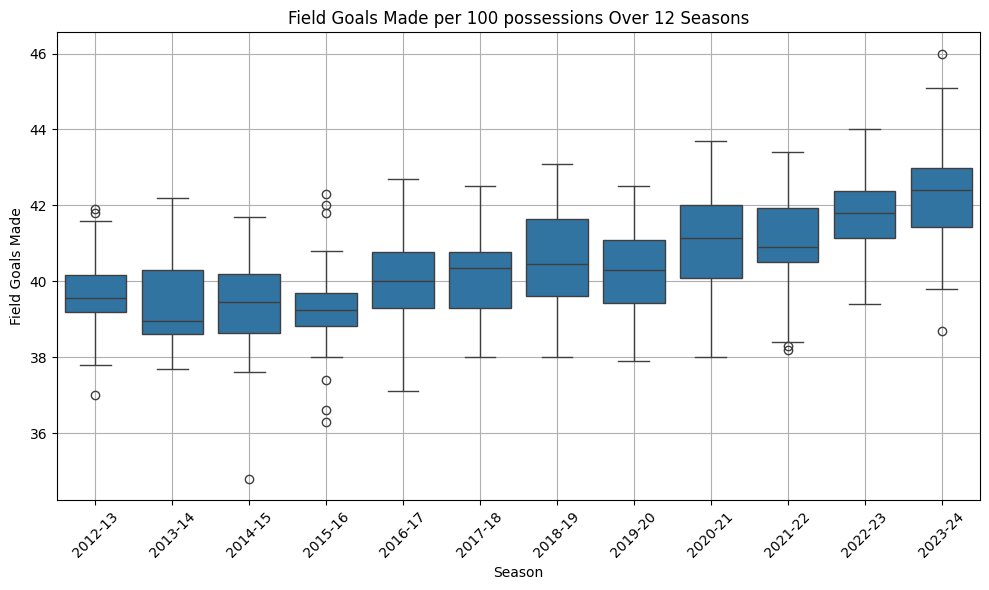

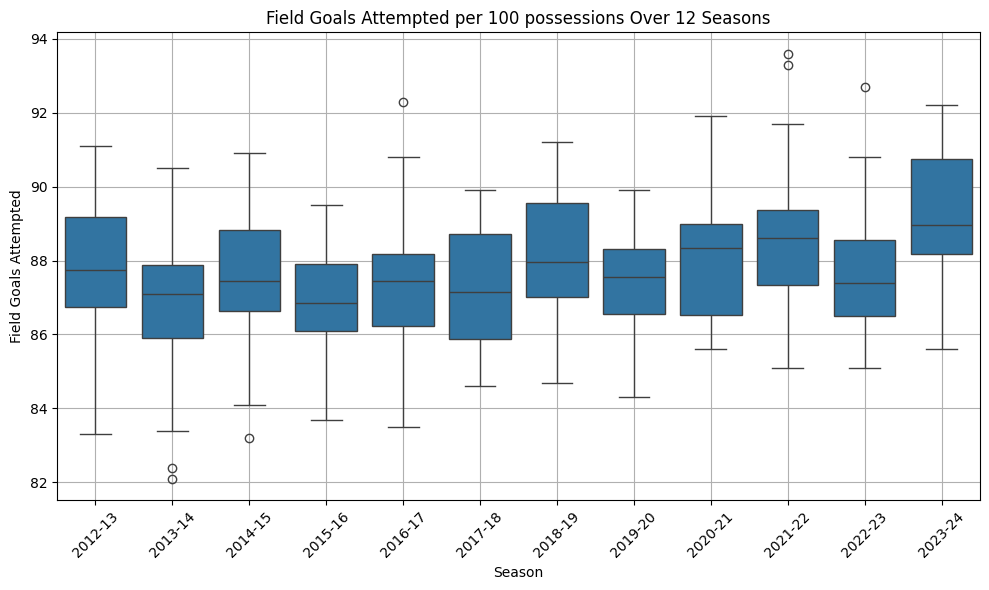

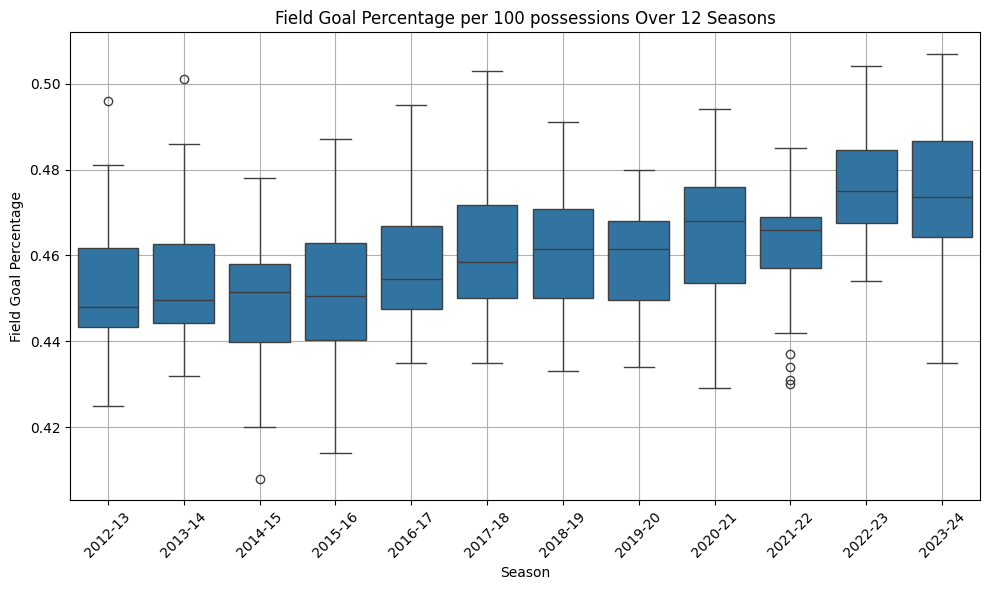

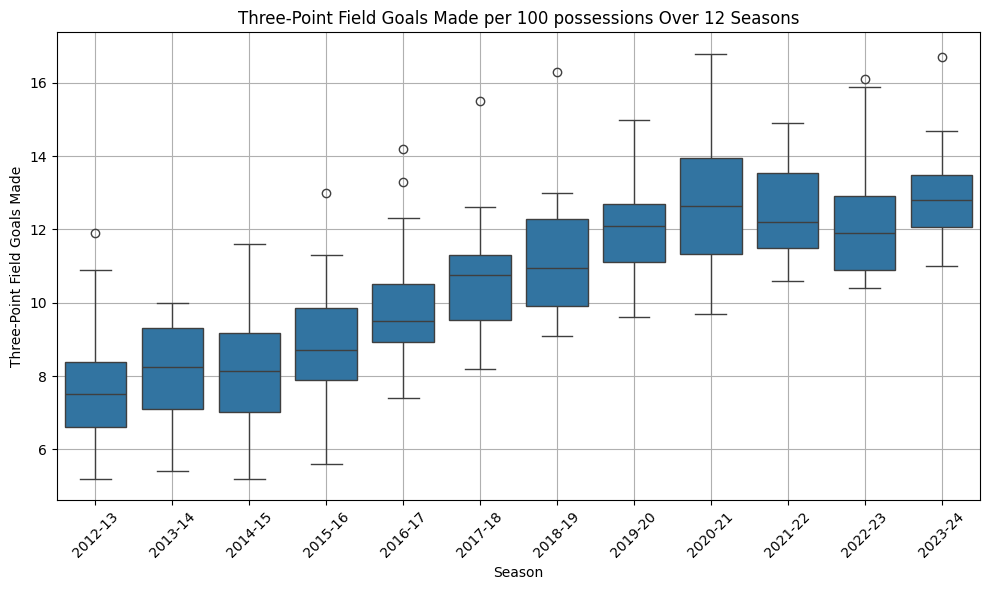

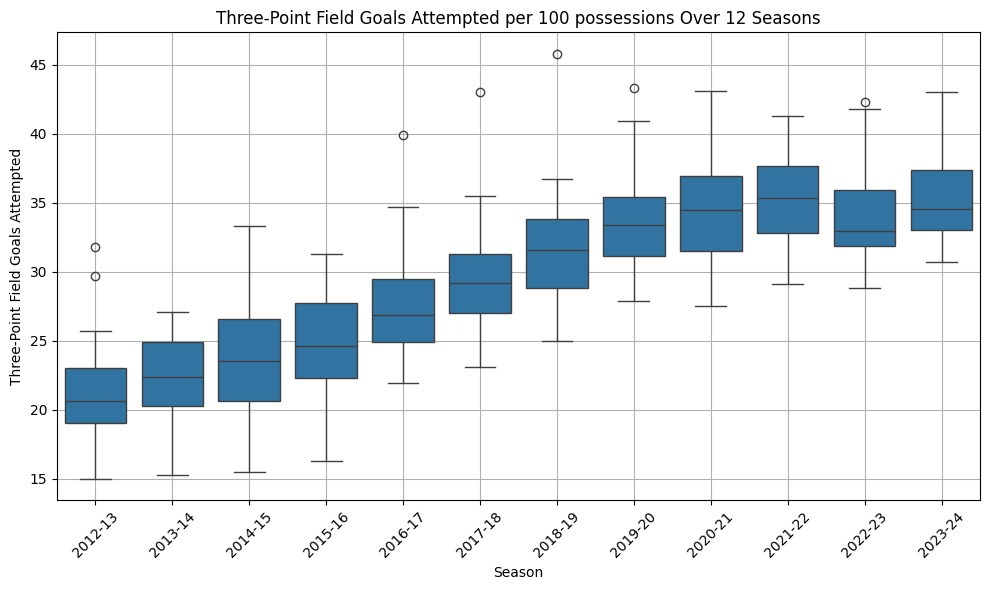

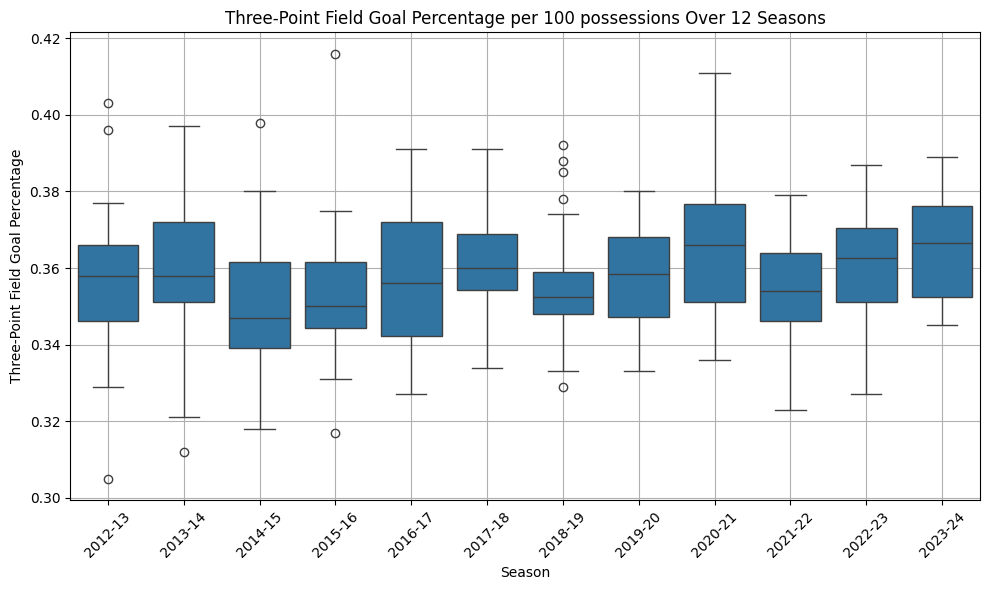

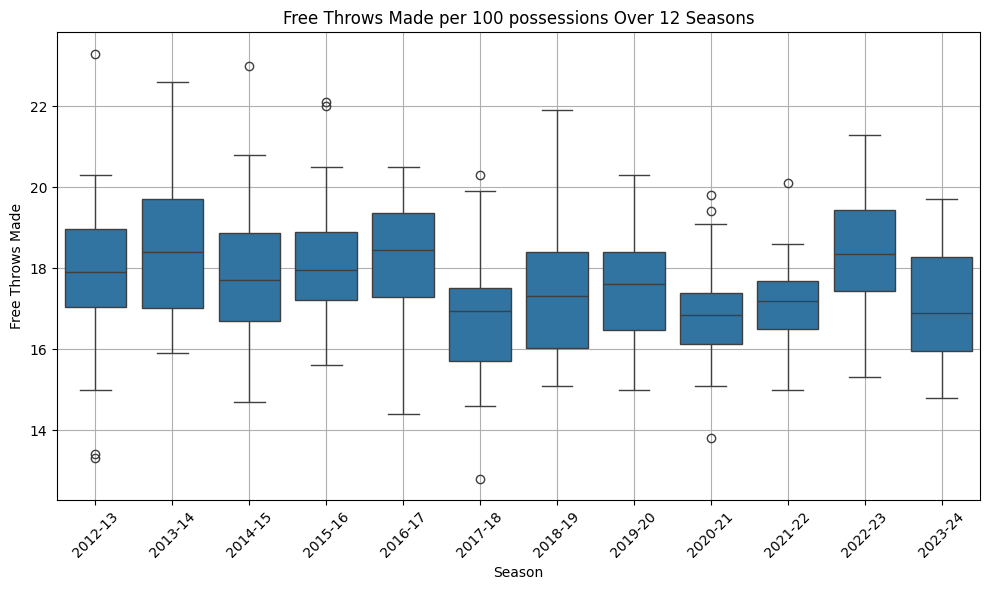

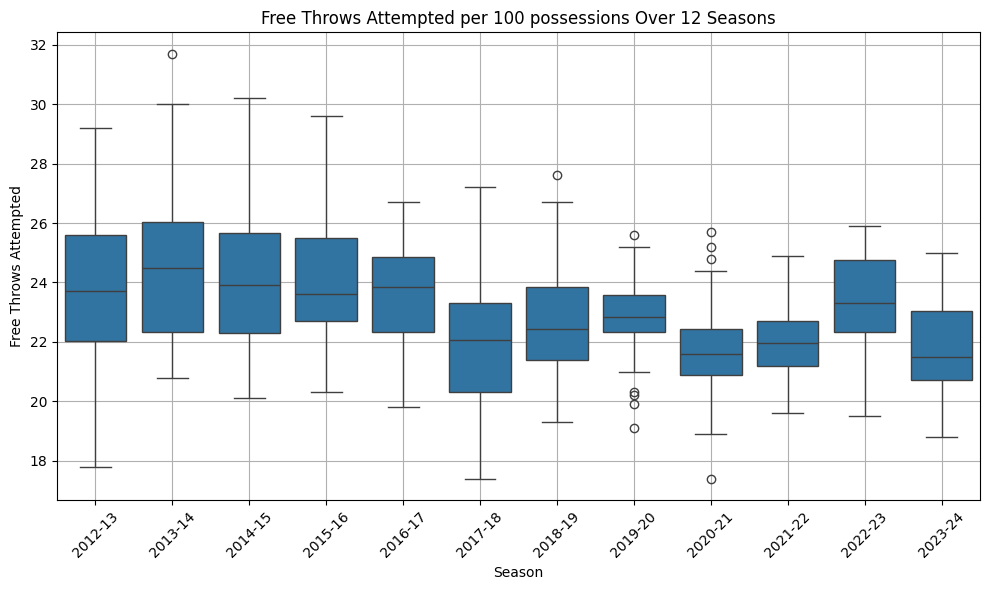

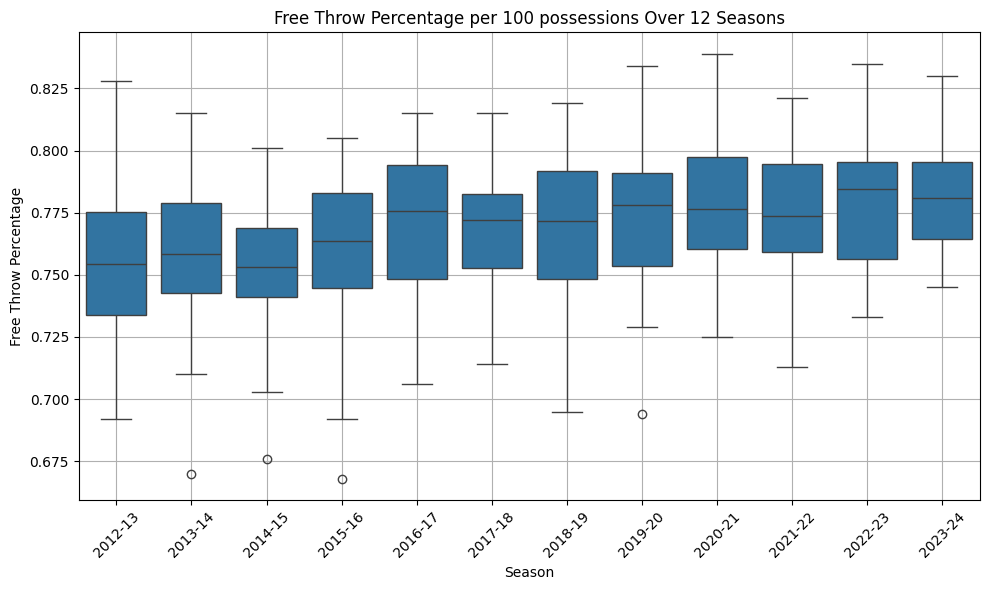

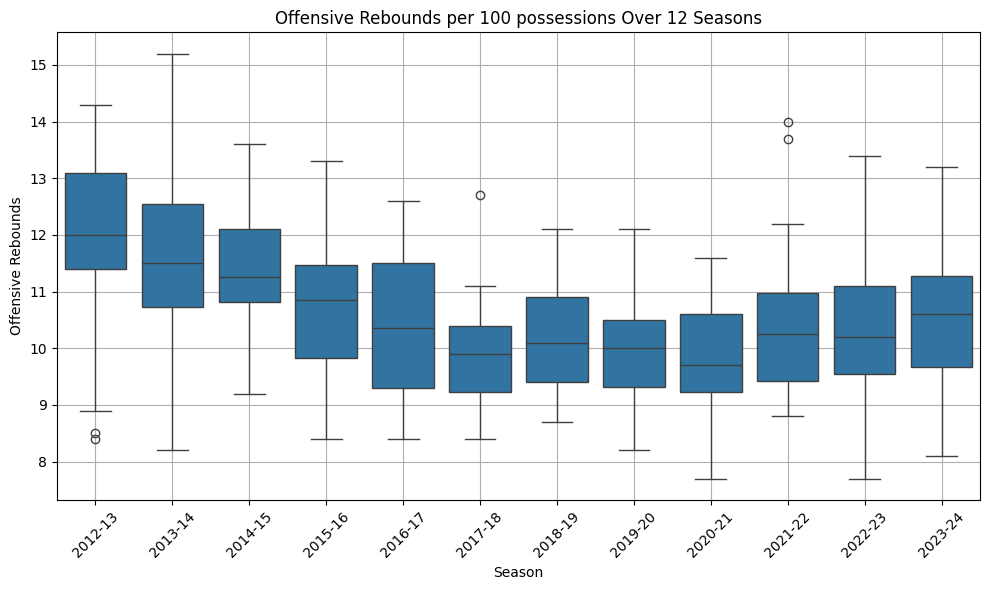

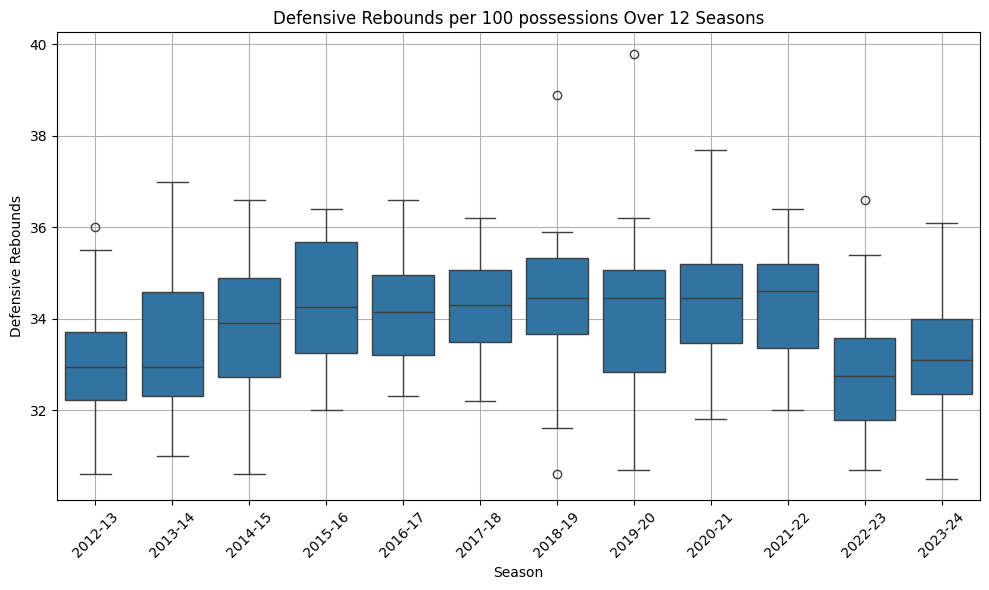

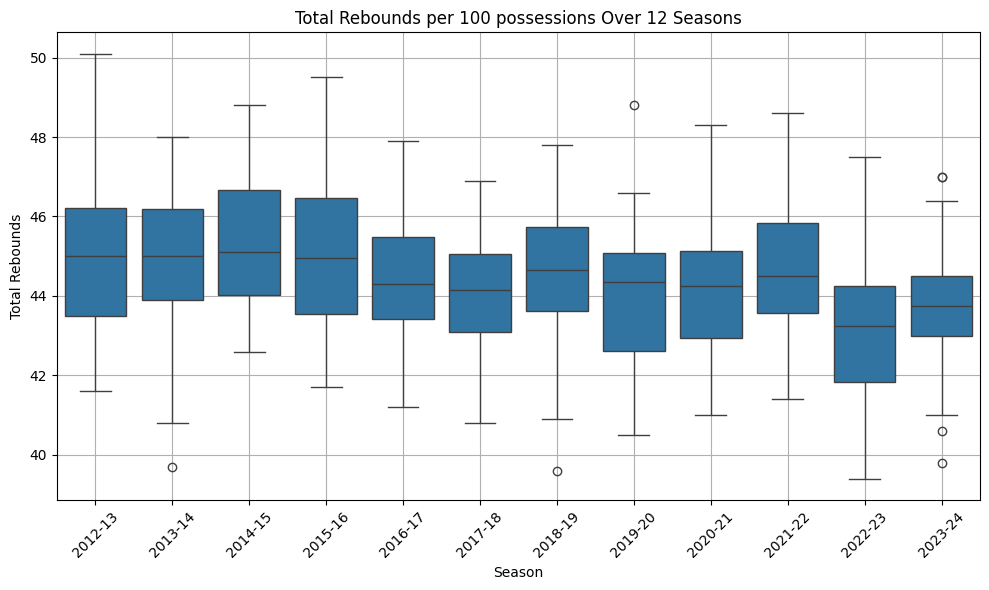

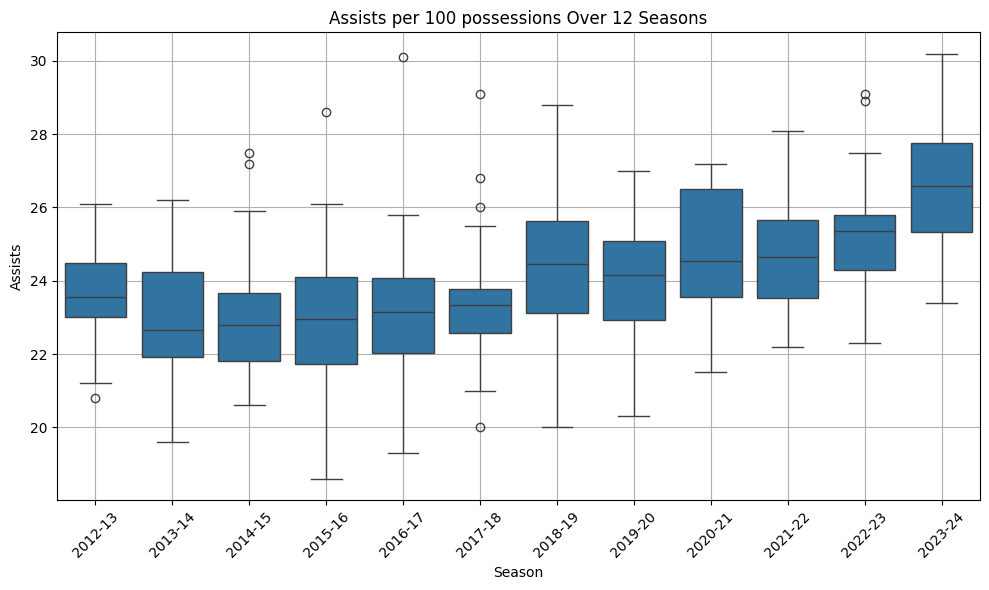

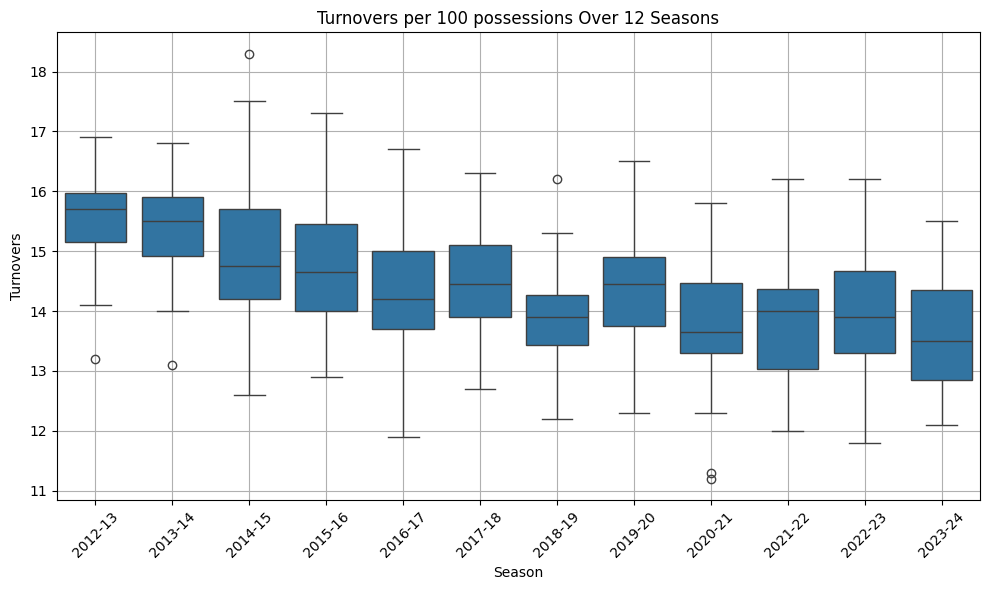

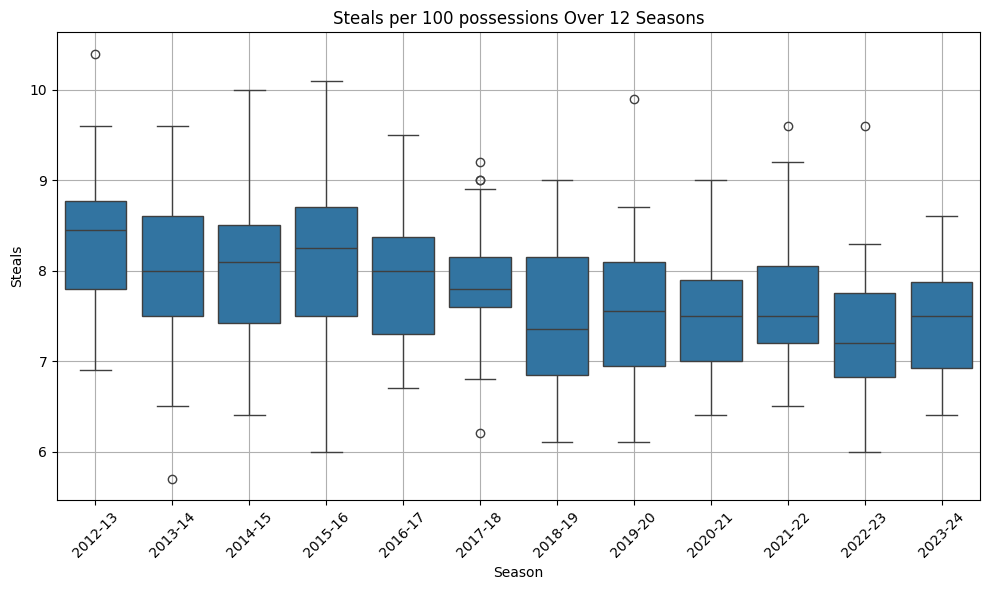

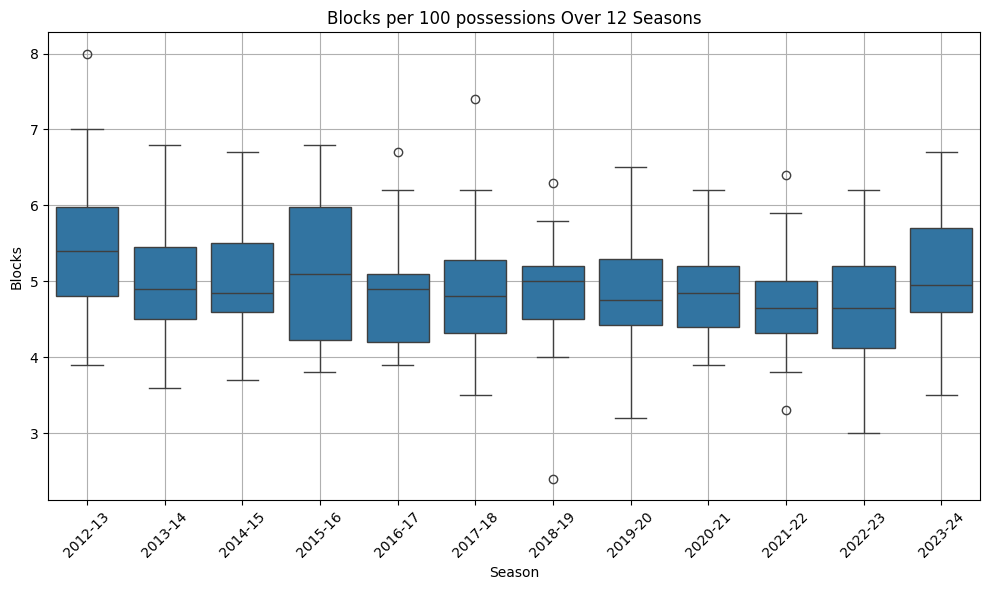

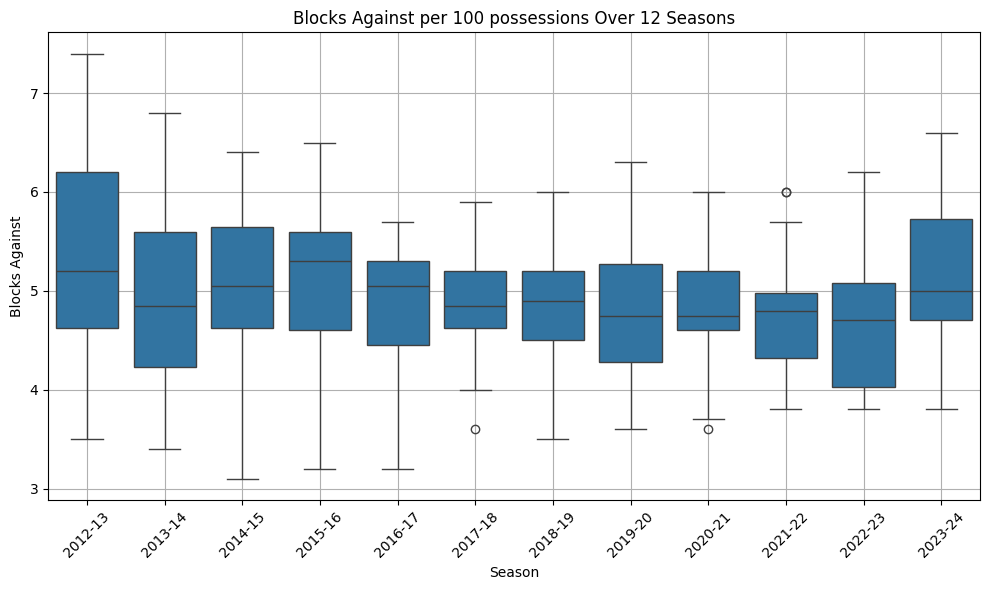

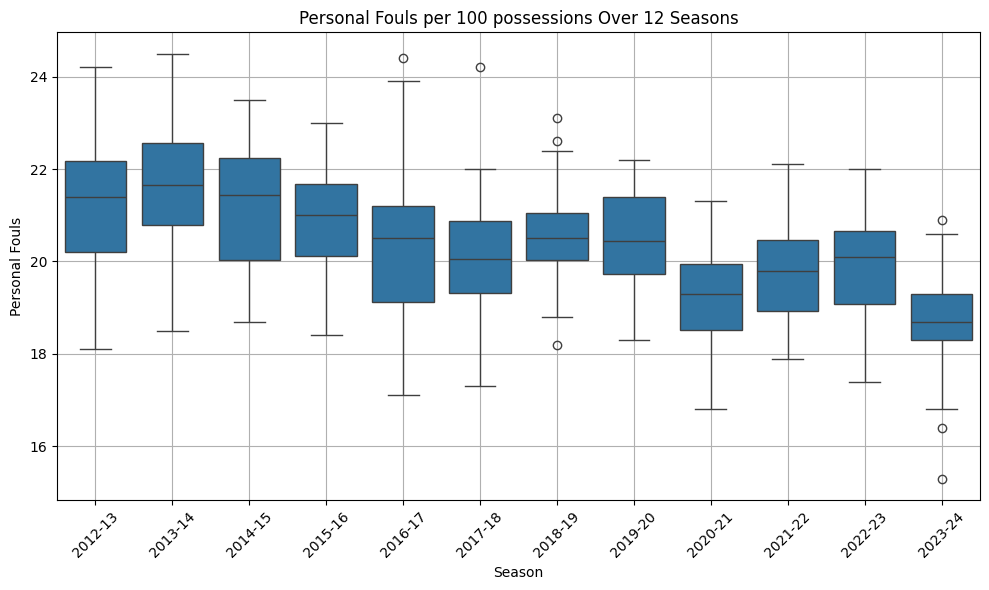

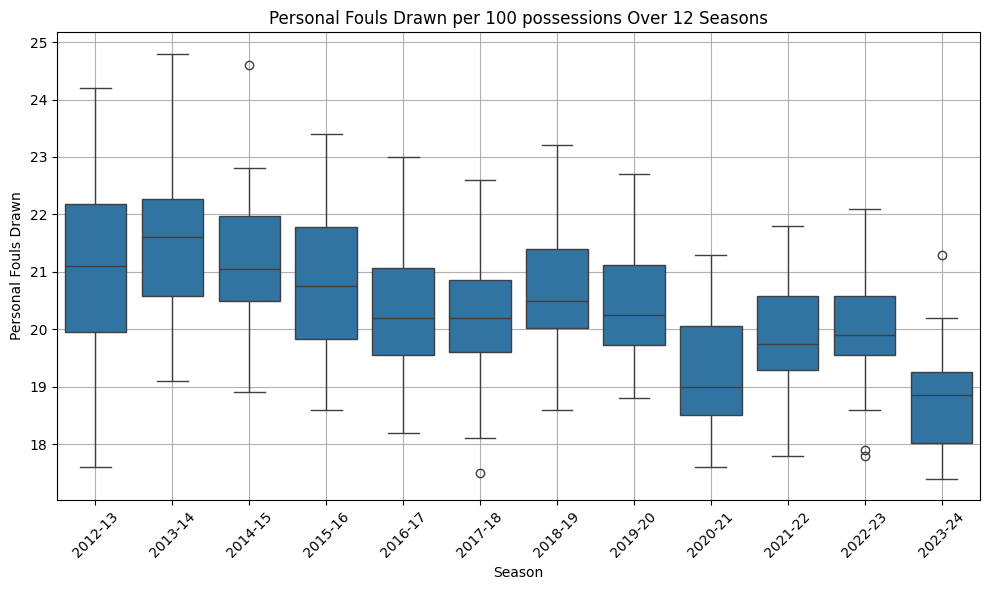

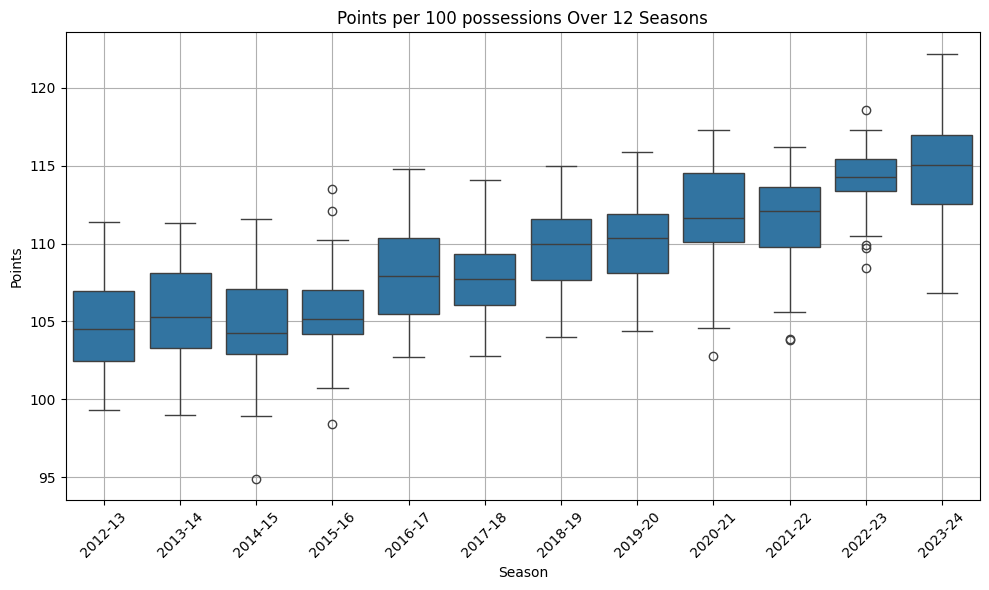

In [9]:
# Assuming team_stats_simple is already loaded and contains the data
# Dictionary for statistic names
stat_name_dict = {
    "FGM": "Field Goals Made", "FGA": "Field Goals Attempted", "FG_PCT": "Field Goal Percentage",
    "FG3M": "Three-Point Field Goals Made", "FG3A": "Three-Point Field Goals Attempted", "FG3_PCT": "Three-Point Field Goal Percentage",
    "FTM": "Free Throws Made", "FTA": "Free Throws Attempted", "FT_PCT": "Free Throw Percentage",
    "OREB": "Offensive Rebounds", "DREB": "Defensive Rebounds", "REB": "Total Rebounds",
    "AST": "Assists", "TOV": "Turnovers", "STL": "Steals", "BLK": "Blocks", "BLKA": "Blocks Against",
    "PF": "Personal Fouls", "PFD": "Personal Fouls Drawn", "PTS": "Points"
}

# Plot boxplots for each statistic per season
for col in ["FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT", "OREB", "DREB", "REB", "AST", "TOV", "STL", "BLK", "BLKA", "PF", "PFD", "PTS"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=team_stats_simple, x="SEASON", y=col)
    plt.title(f"{stat_name_dict[col]} per 100 possessions Over 12 Seasons")
    plt.xlabel("Season")
    plt.ylabel(stat_name_dict[col])
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

A  Base csoport trendjei között a legegyértelműbb, hogy egyre több pontot dobtak a csapatok az évek során. Ez leginkább annak köszönhető, hogy a ráemelt, és bedobott hárompontosok is hasonló trendet mutat. Érdekesség, hogy egyre kevesebb faultot harcoltak ki a csapatok, aminek köszönhetően egyre kevesebb büntetőt is dobtak rá. Ellenben ezeket egyre pontosabban értékesítették. Ezekell párhuzamosan több téren pontosabbak lettek a játékosok: az eladott labdák száma csökkenő trendet mutatott, a mezőnydobások hatékonysága pedig enyhén emelkedőt.

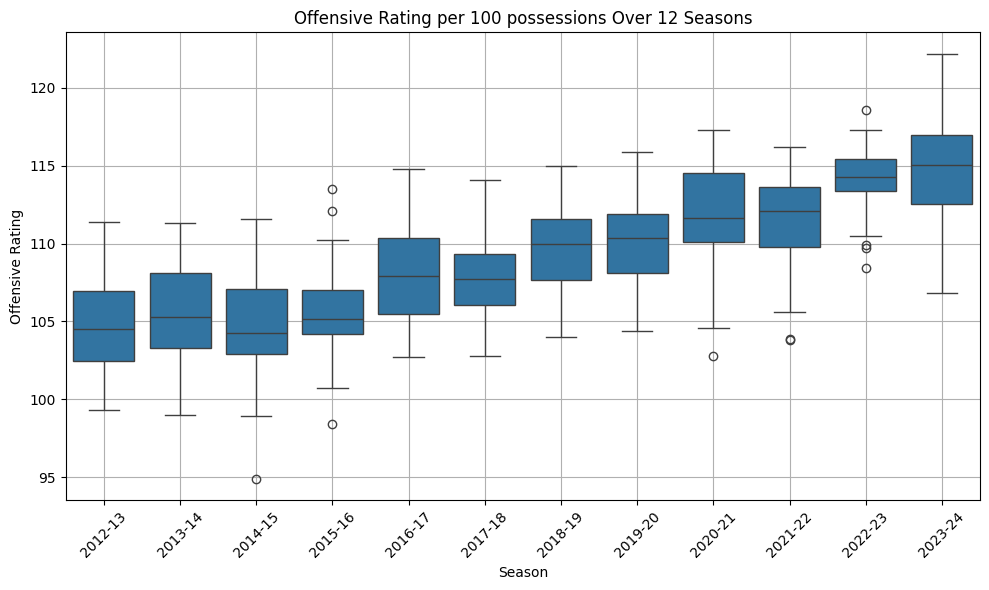

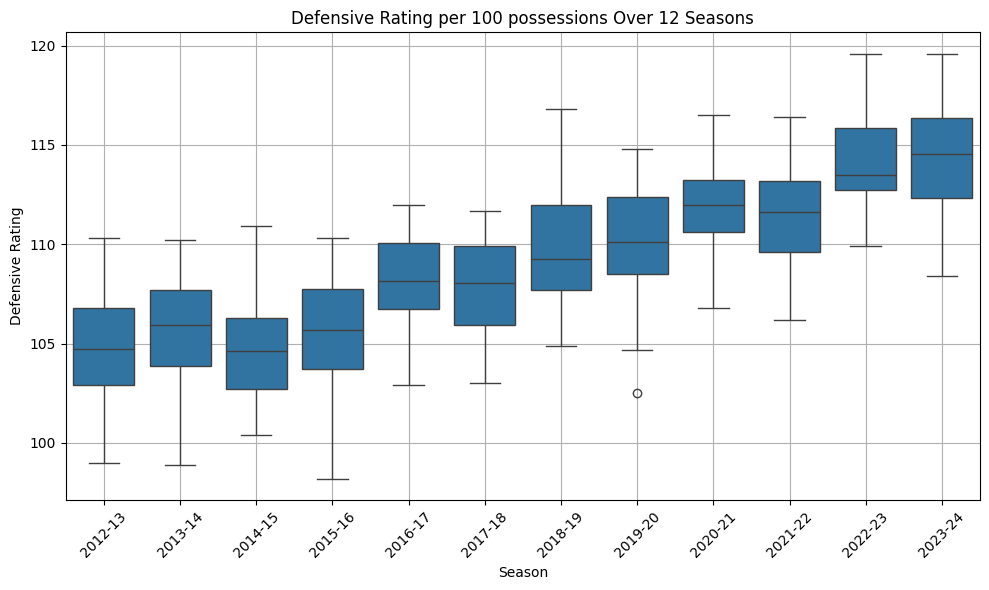

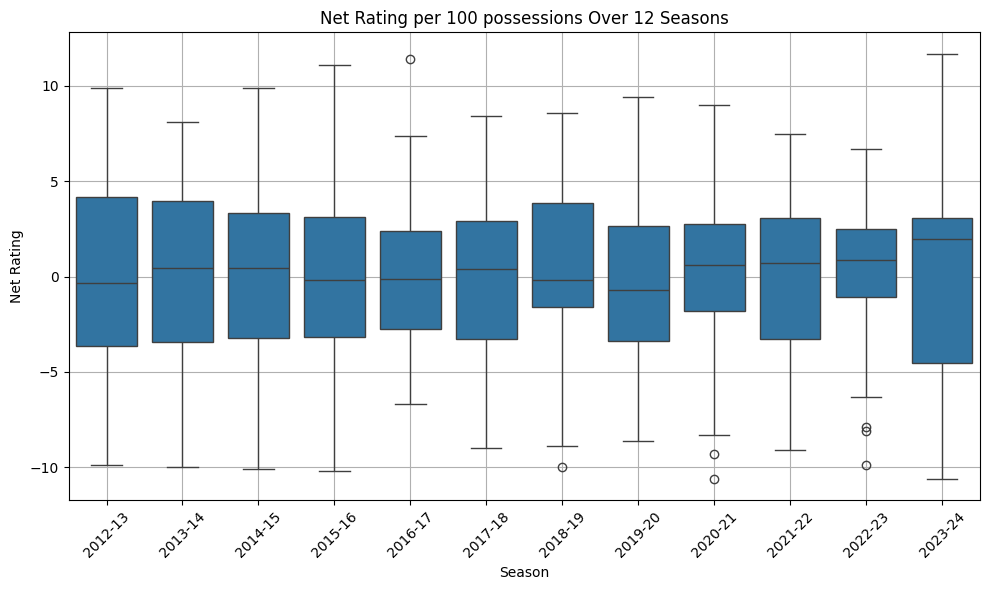

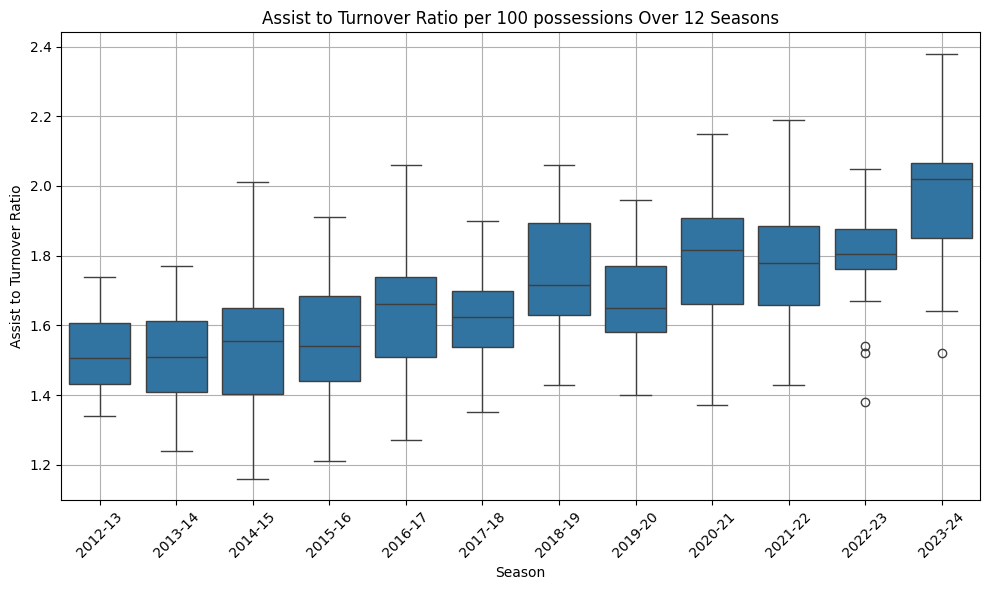

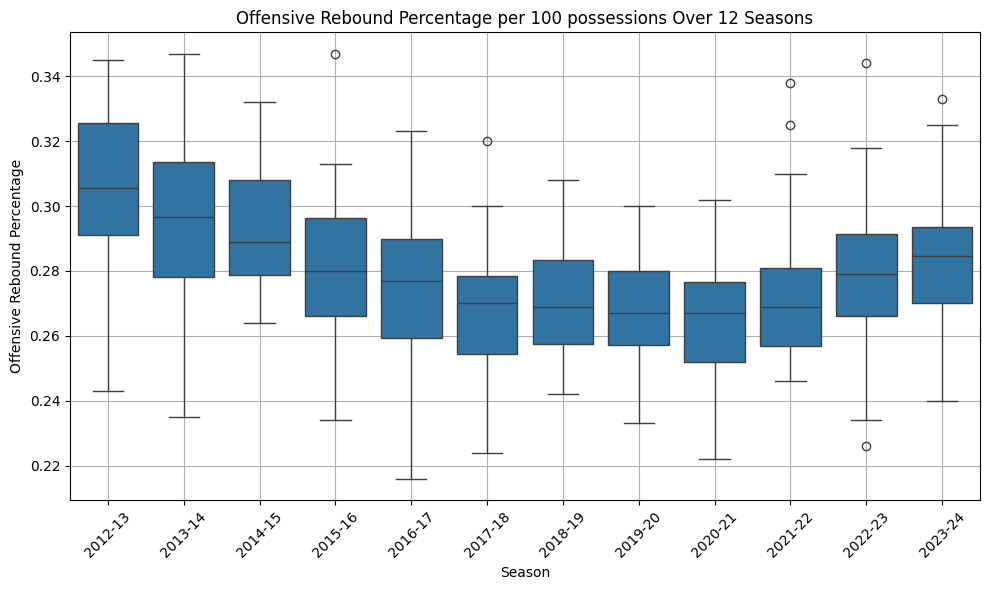

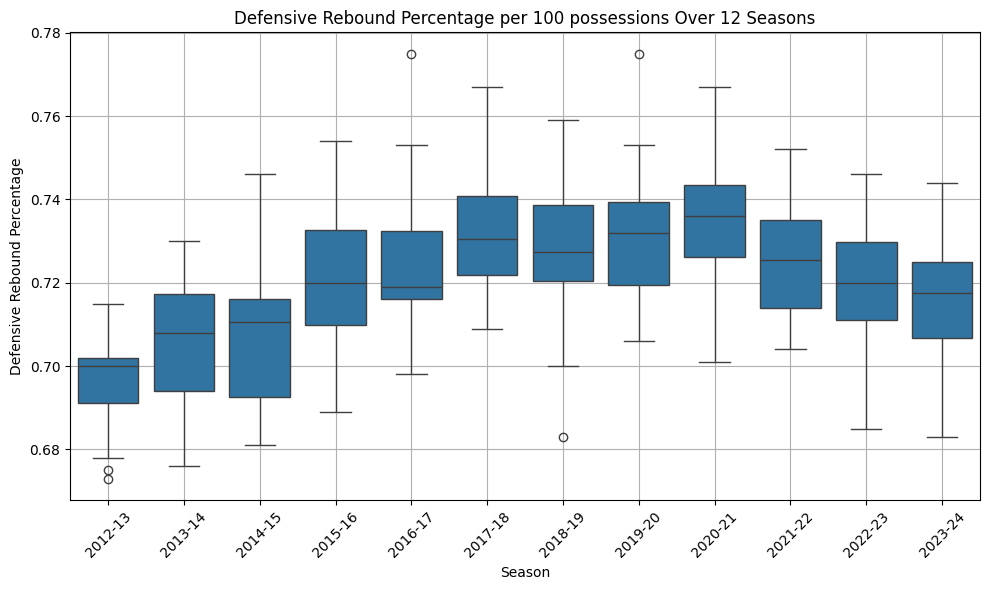

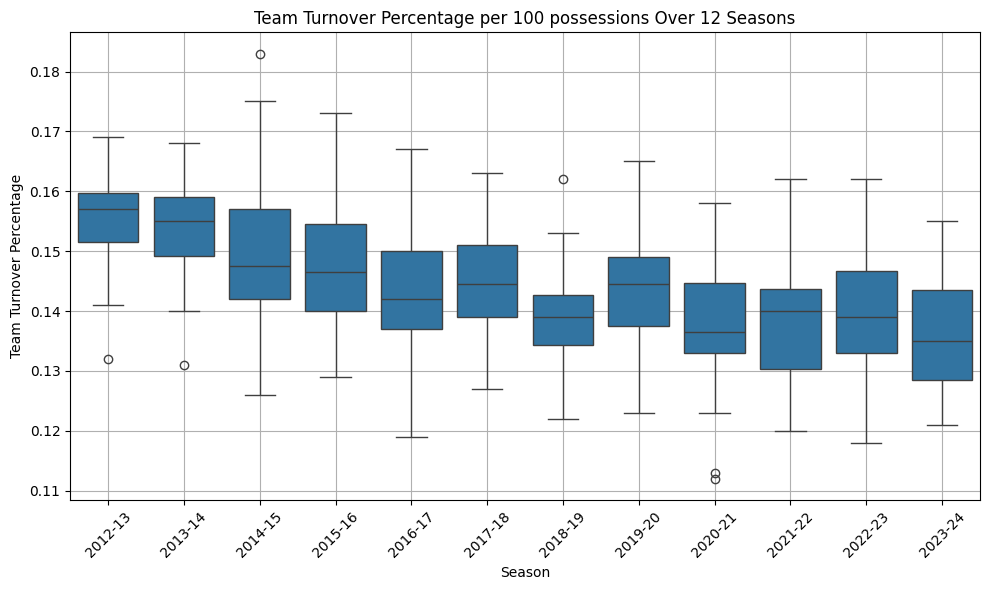

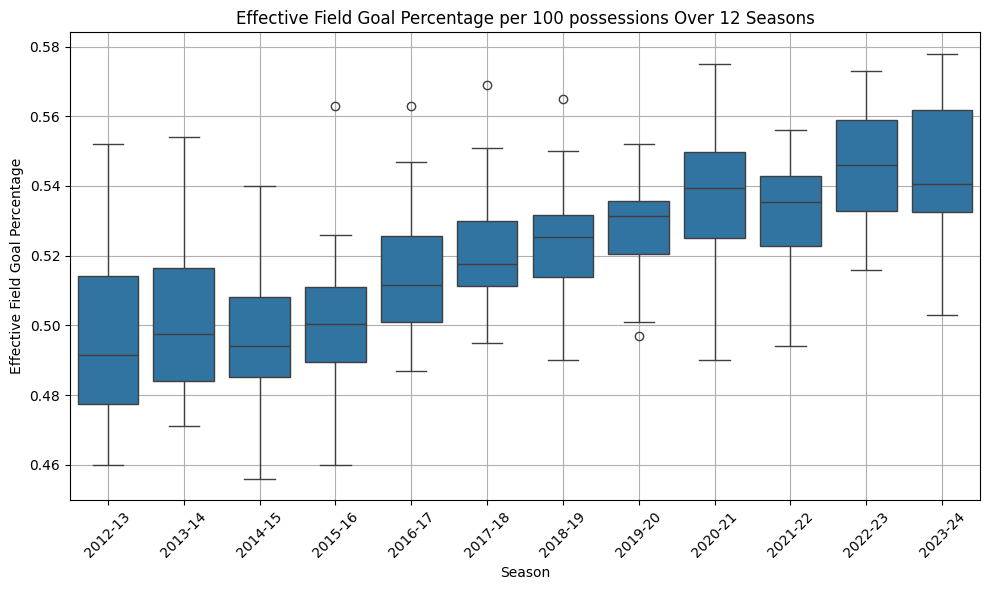

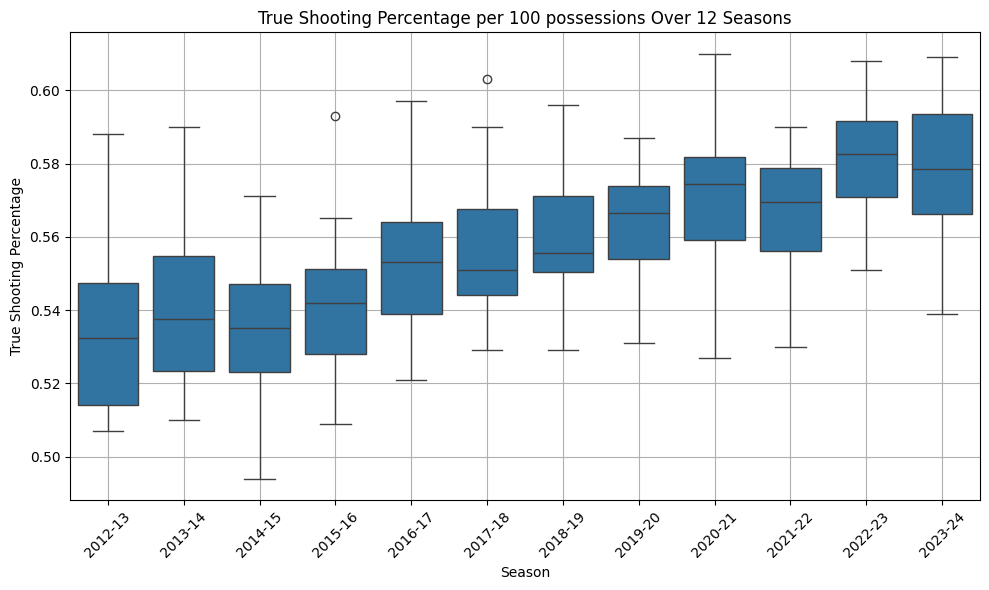

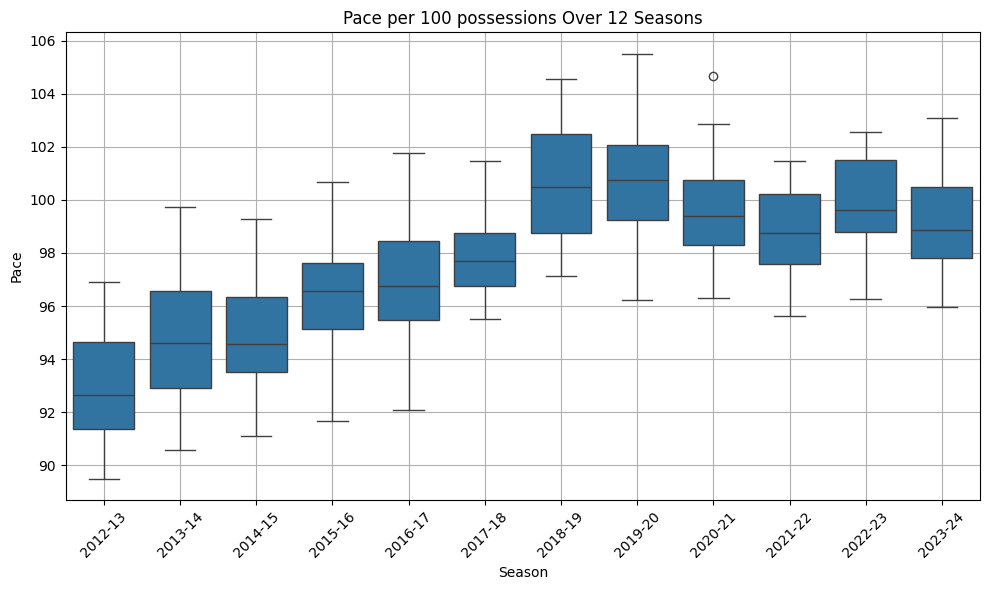

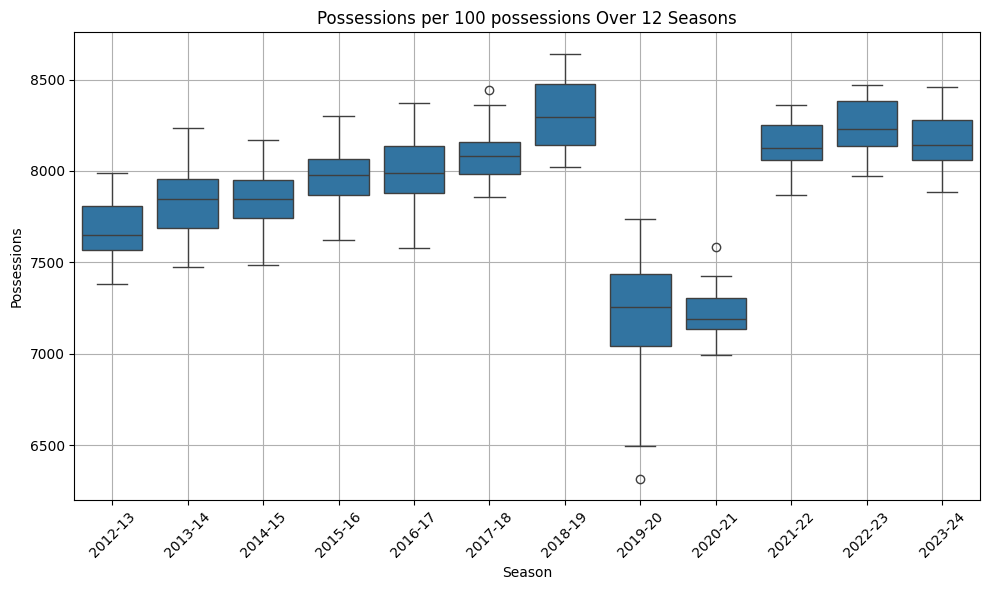

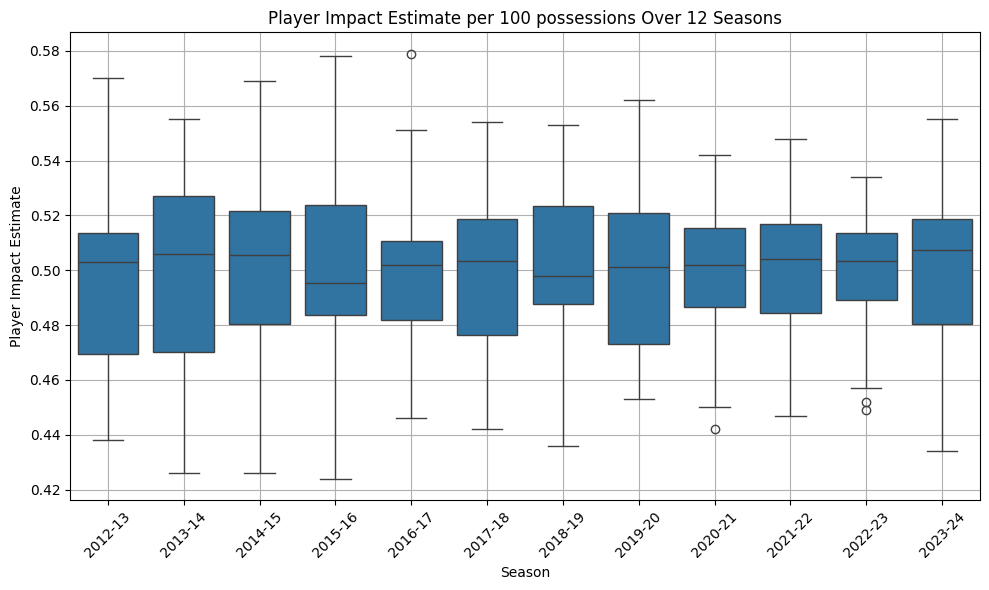

In [10]:
# Assuming team_stats_simple is already loaded and contains the data
# Dictionary for statistic names
stat_name_dict = {
    "OFF_RATING": "Offensive Rating", "DEF_RATING": "Defensive Rating", "NET_RATING": "Net Rating",
    "AST_TO": "Assist to Turnover Ratio", "AST_RATIO": "Assist Ratio", "OREB_PCT": "Offensive Rebound Percentage",
    "DREB_PCT": "Defensive Rebound Percentage", "REB_PCT": "Rebound Percentage", "TM_TOV_PCT": "Team Turnover Percentage",
    "EFG_PCT": "Effective Field Goal Percentage", "TS_PCT": "True Shooting Percentage", "PACE": "Pace",
    "PACE_PER40": "Pace Per 40 Minutes", "POSS": "Possessions", "PIE": "Player Impact Estimate"

}

# Plot boxplots for each statistic per season
for col in ["OFF_RATING","DEF_RATING","NET_RATING","AST_TO","OREB_PCT","DREB_PCT","TM_TOV_PCT","EFG_PCT","TS_PCT","PACE","POSS","PIE"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=team_stats_simple, x="SEASON", y=col)
    plt.title(f"{stat_name_dict[col]} per 100 possessions Over 12 Seasons")
    plt.xlabel("Season")
    plt.ylabel(stat_name_dict[col])
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

A legtöbb Advanced statisztika trendje jól magyarázható a korábban látottakkal. A dobott pontok növekvő trendje természetesen az Offensive ratinget (és Defensive ratinget is) magával húzta. Az, hogy egyre több triplát dobtak a csapatok, viszonylag hasonló százalékkal, mint korábban, egyre növekvő Effektív mezőnyszázalékokat eredményezett (az effektív mezőnyszázalék a dobható pontokkal súlyozott mezőnyszázalék). A támadó boom valószínűleg annak is köszönhető, hogy egyre gyorsabban játszanak a csapatok. Erre utal a növekvő Pace és Possessions (labdabirtoklás) trend.

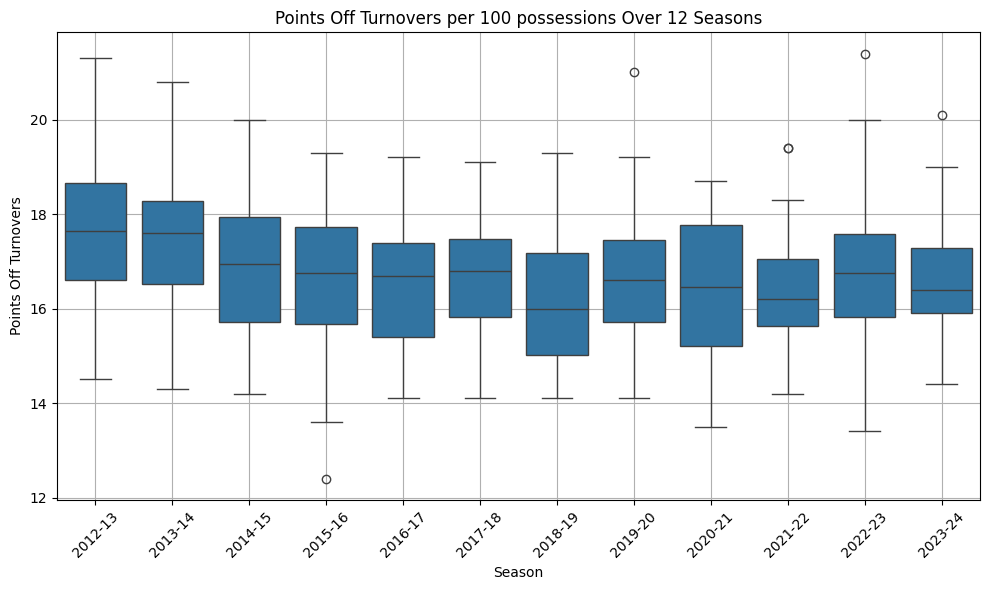

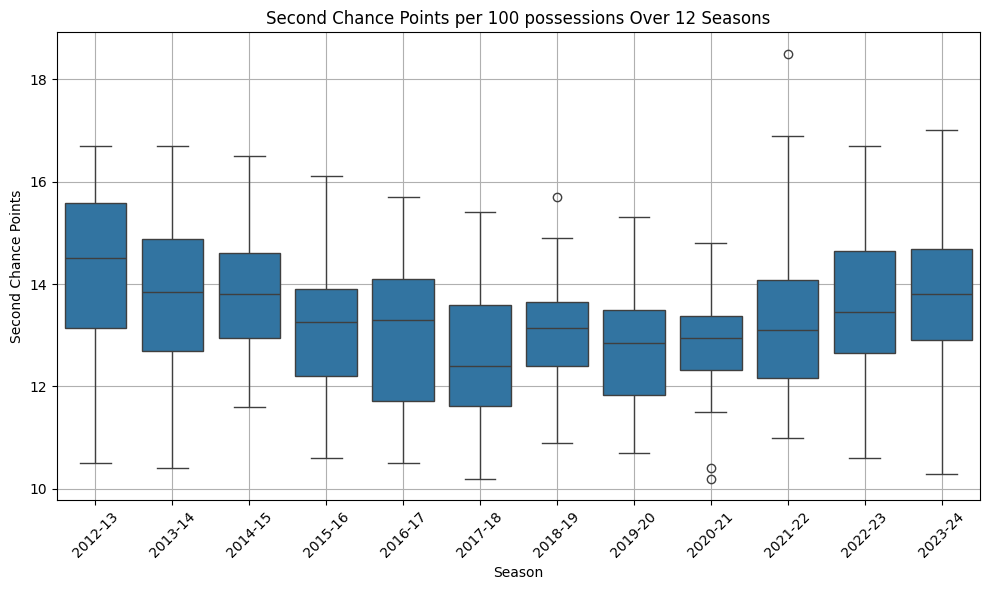

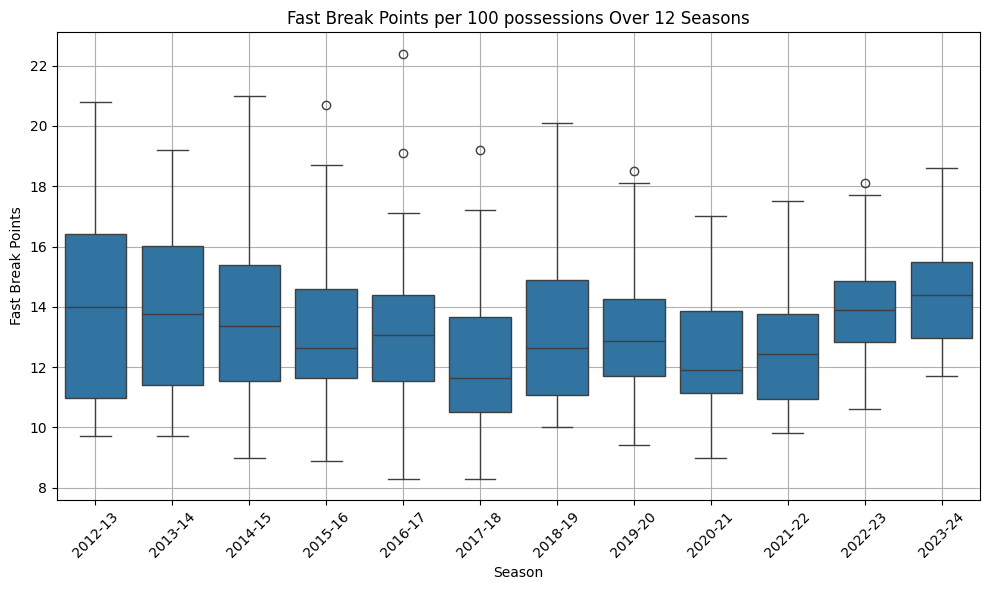

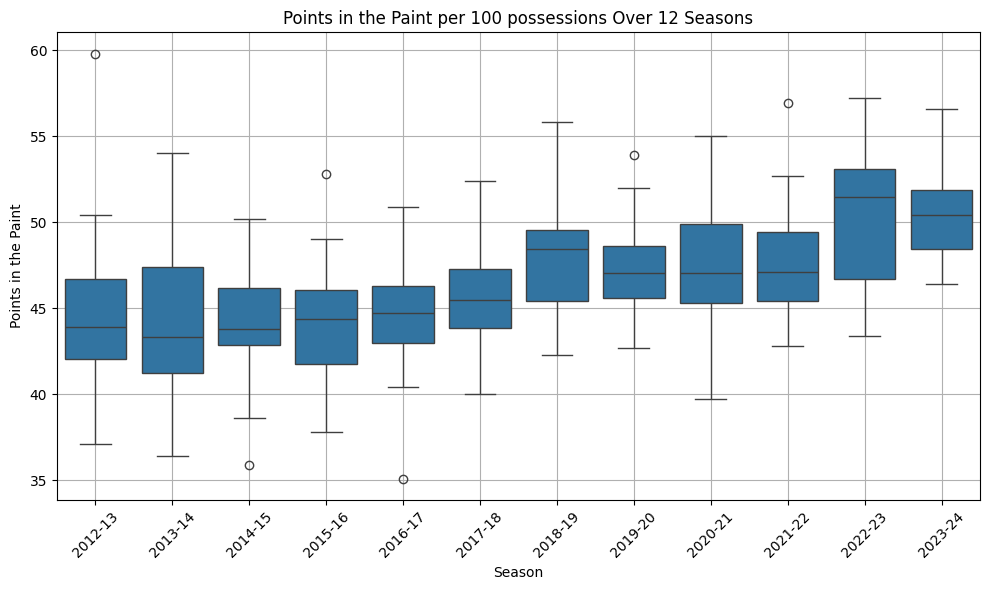

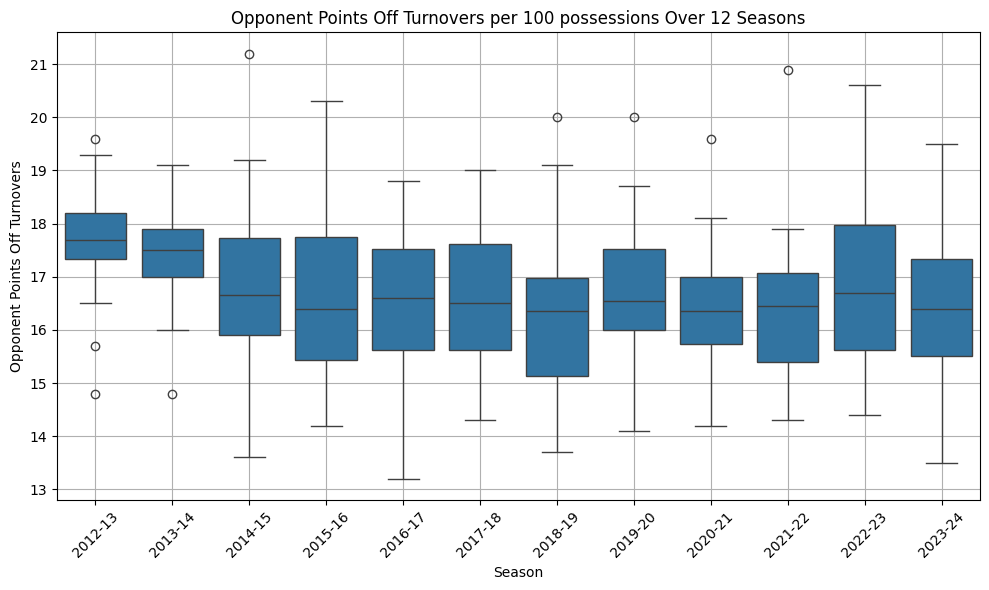

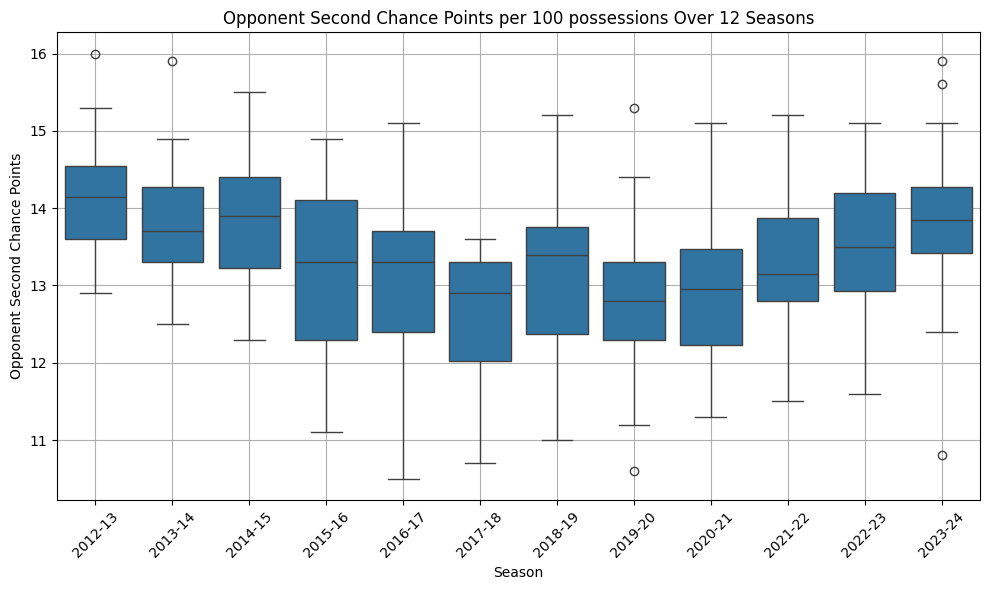

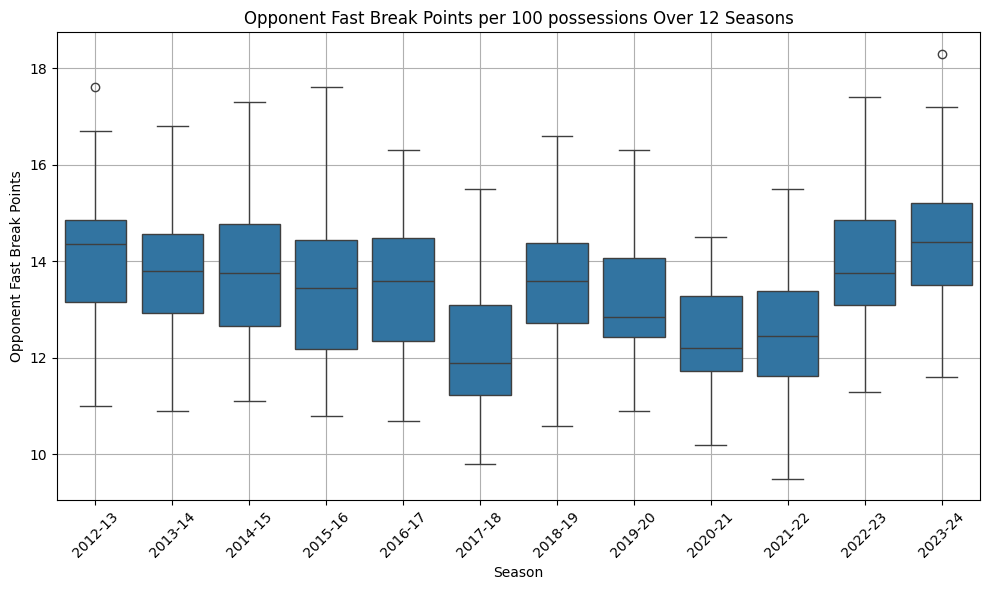

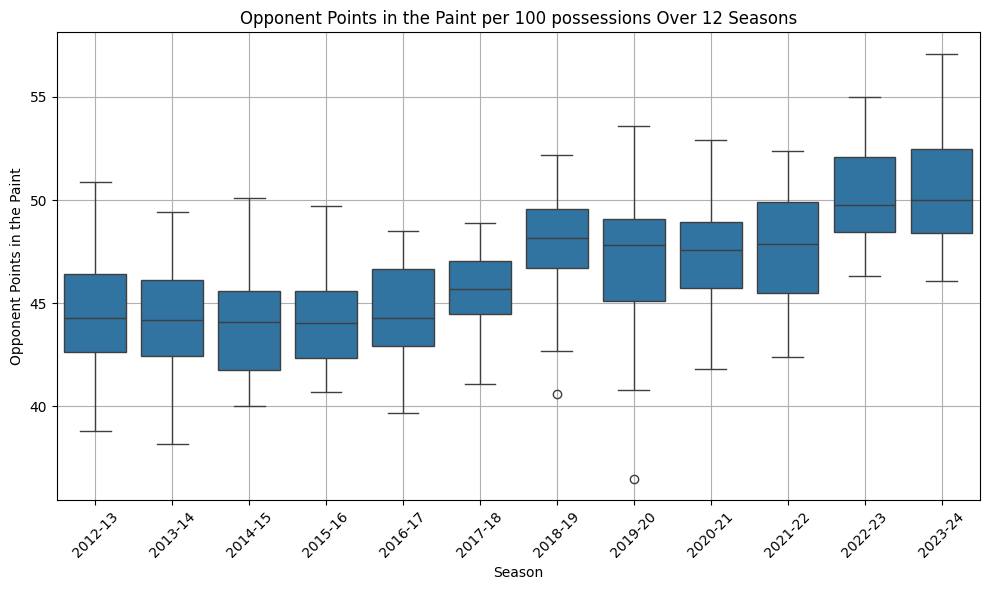

In [11]:

# Assuming team_stats_simple is already loaded and contains the data
# Dictionary for statistic names
stat_name_dict = {
    "PTS_OFF_TOV": "Points Off Turnovers", "PTS_2ND_CHANCE": "Second Chance Points", "PTS_FB": "Fast Break Points",
    "PTS_PAINT": "Points in the Paint", "OPP_PTS_OFF_TOV": "Opponent Points Off Turnovers",
    "OPP_PTS_2ND_CHANCE": "Opponent Second Chance Points", "OPP_PTS_FB": "Opponent Fast Break Points",
    "OPP_PTS_PAINT": "Opponent Points in the Paint"
}

# Plot boxplots for each statistic per season
for col in ["PTS_OFF_TOV","PTS_2ND_CHANCE","PTS_FB","PTS_PAINT","OPP_PTS_OFF_TOV","OPP_PTS_2ND_CHANCE","OPP_PTS_FB","OPP_PTS_PAINT"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=team_stats_simple, x="SEASON", y=col)
    plt.title(f"{stat_name_dict[col]} per 100 possessions Over 12 Seasons")
    plt.xlabel("Season")
    plt.ylabel(stat_name_dict[col])
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

A Misc csoportban az egyetlen nem konstans trend a festékből dobott pontoknál figyelhető meg. Ez (természetesen) mind a csapatoknál, mind ellenfeleiknél pozitív.

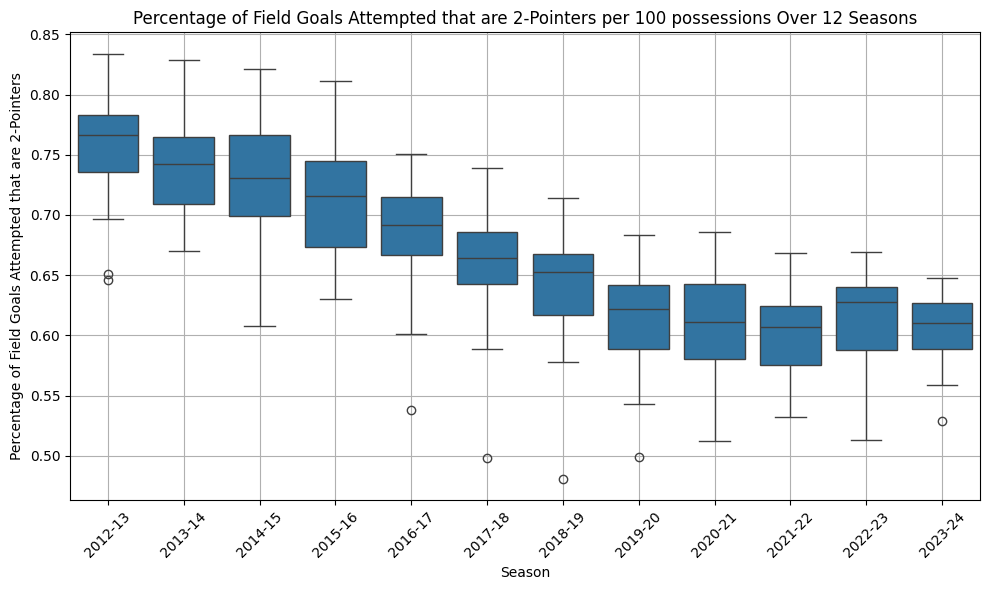

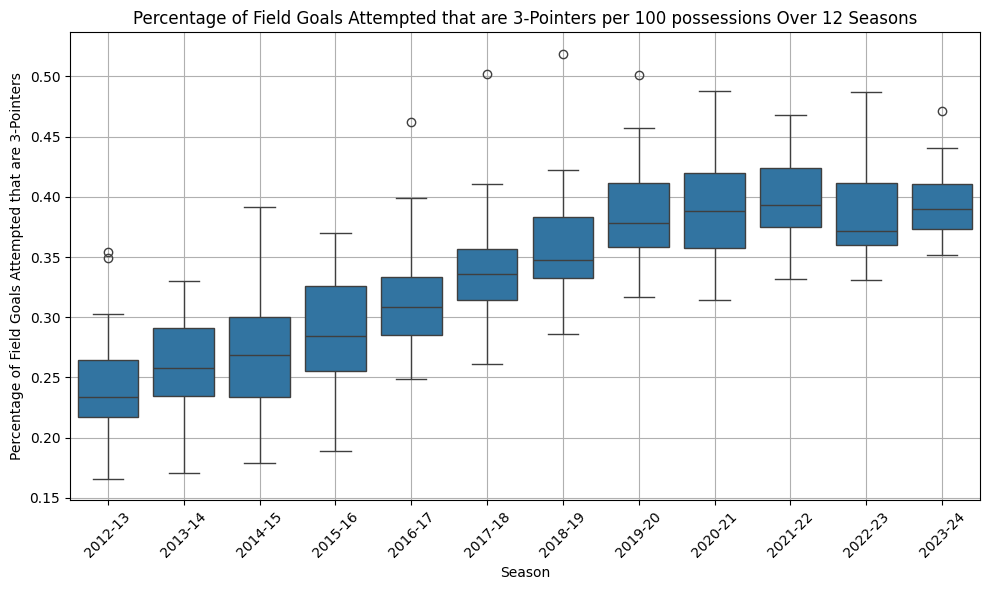

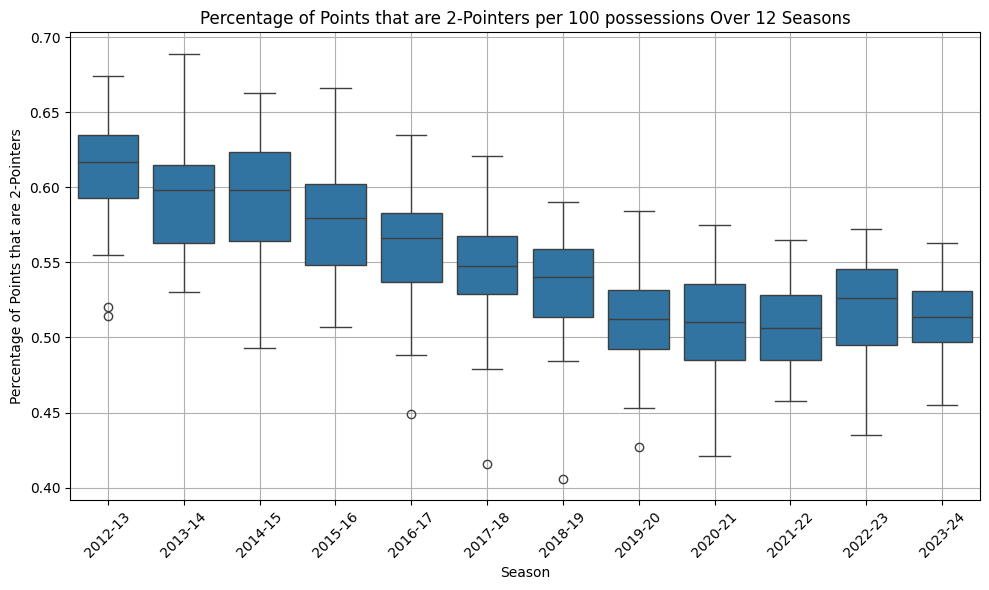

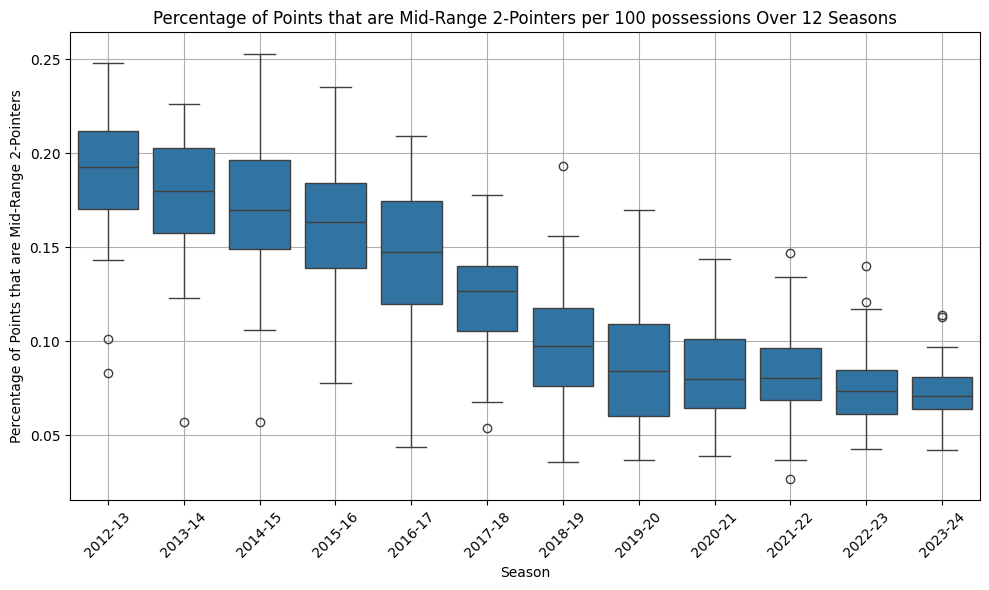

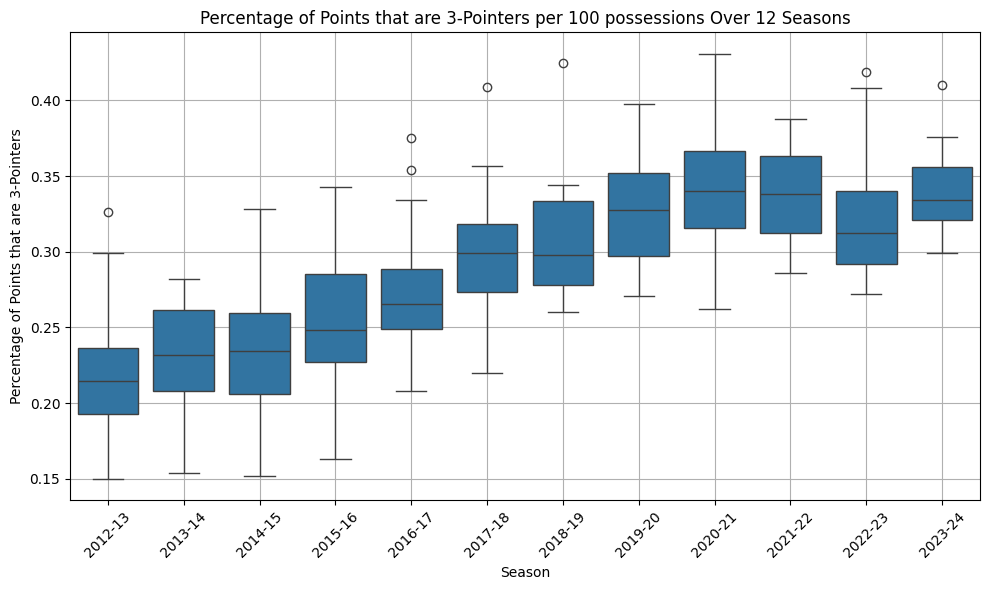

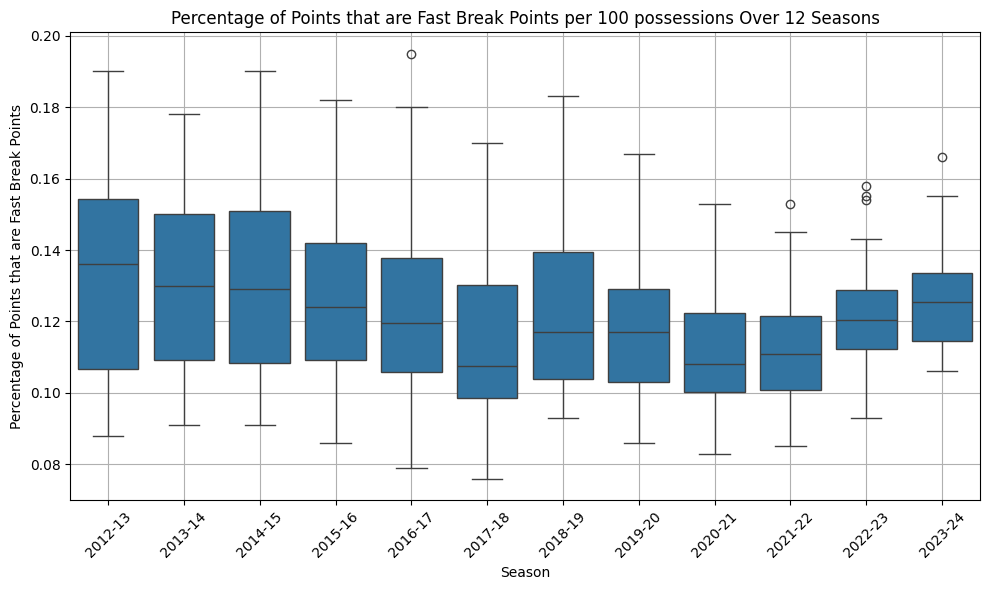

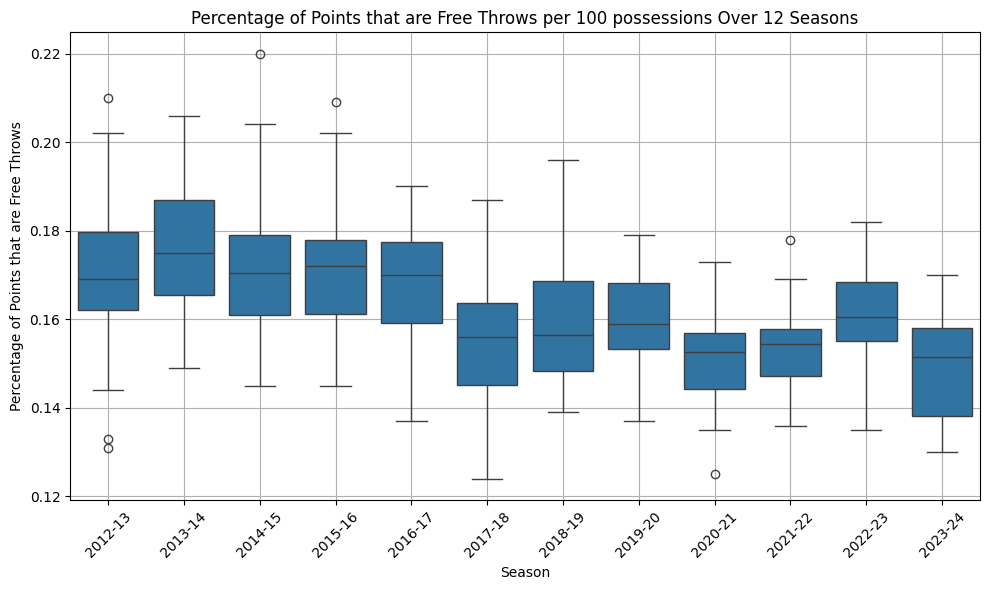

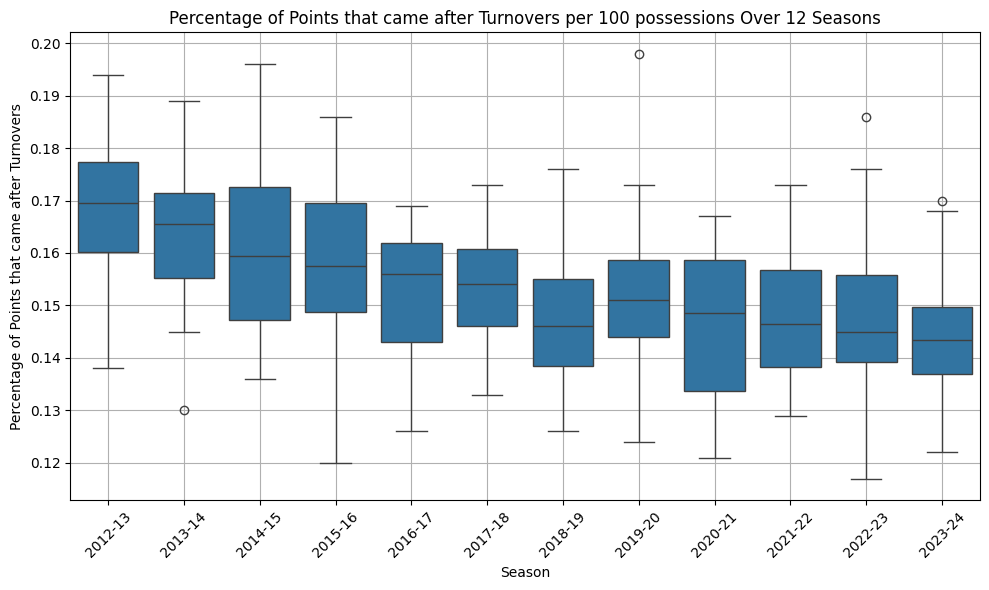

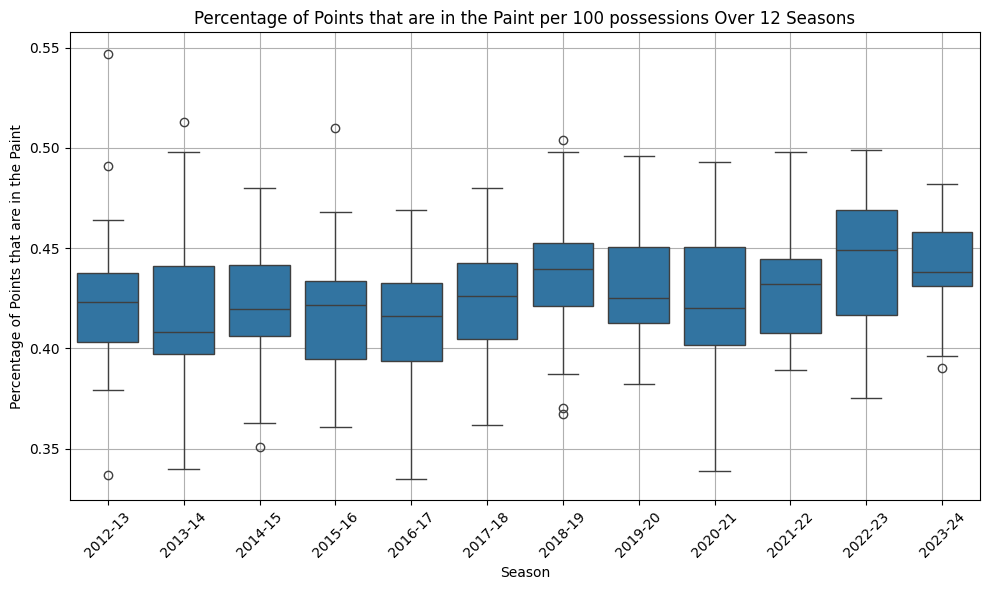

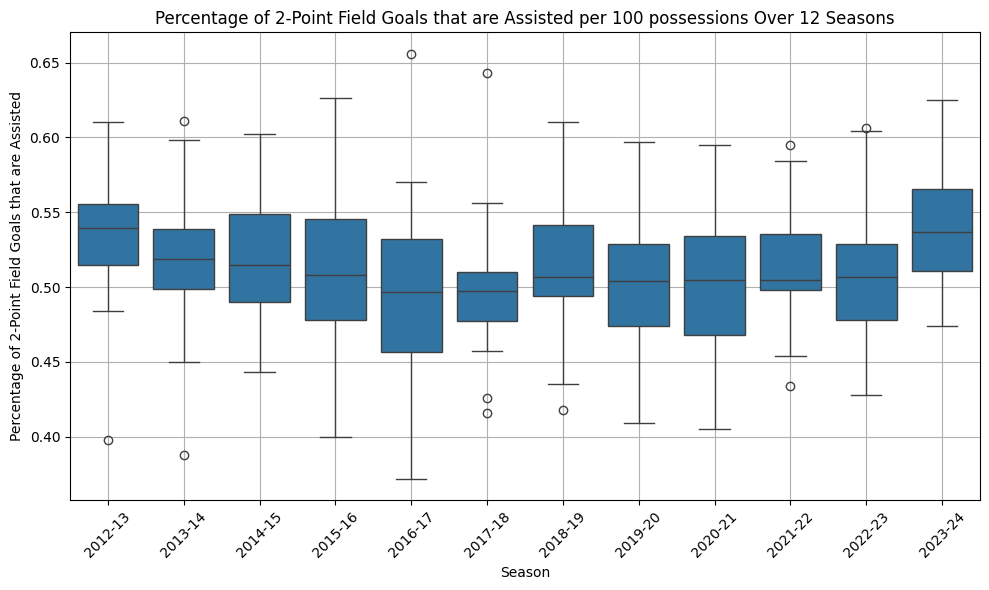

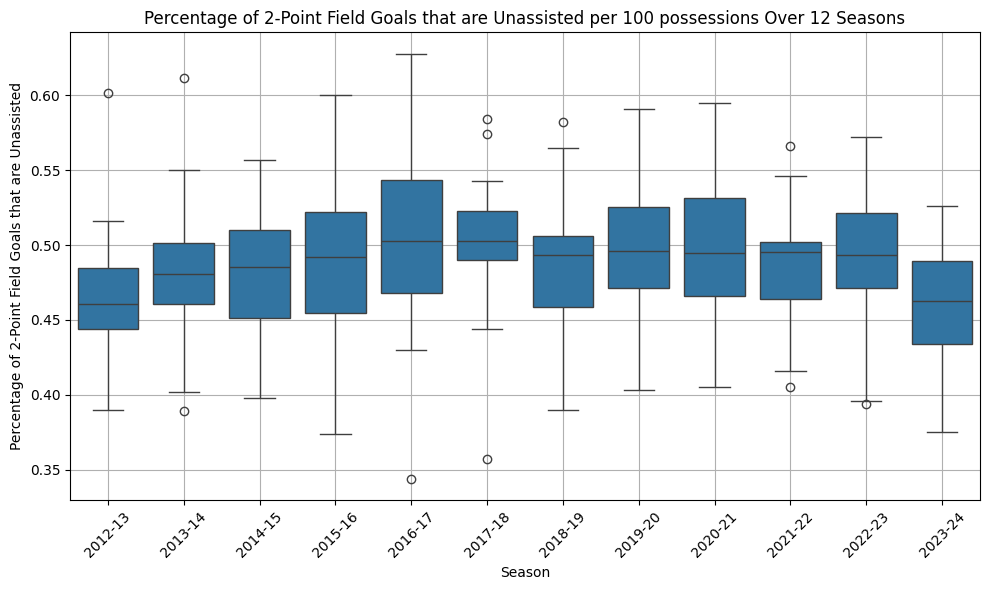

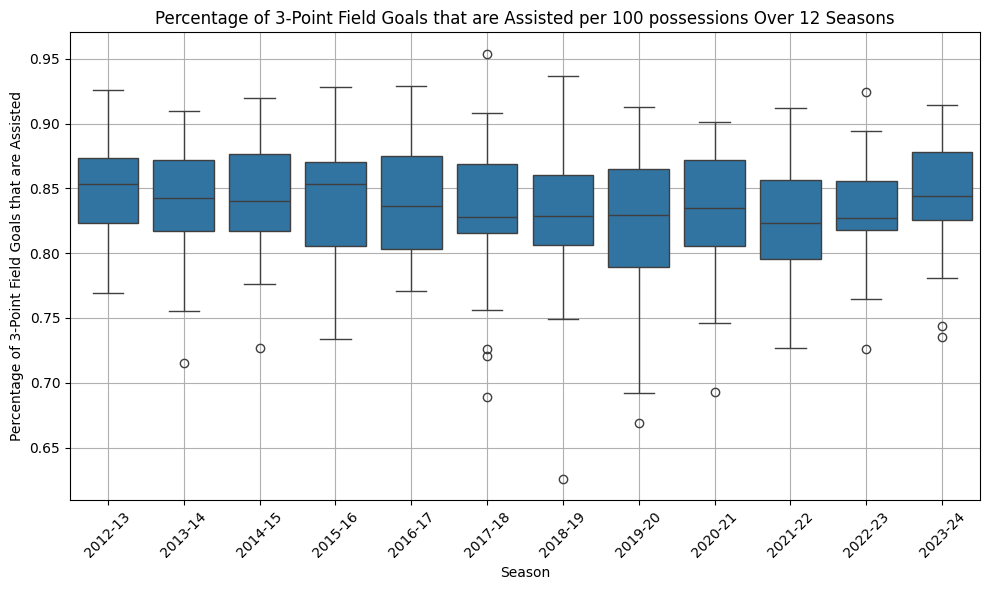

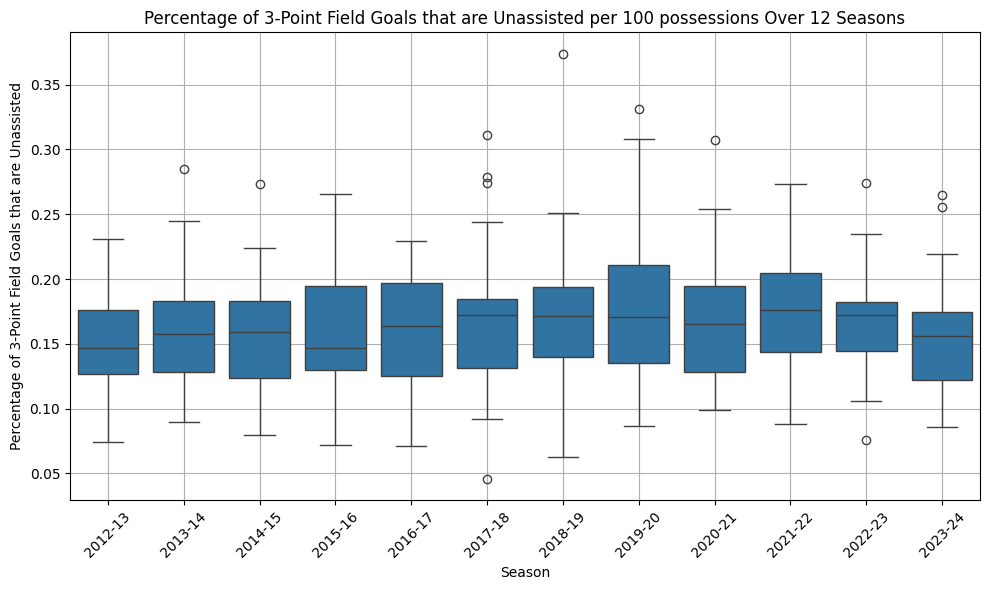

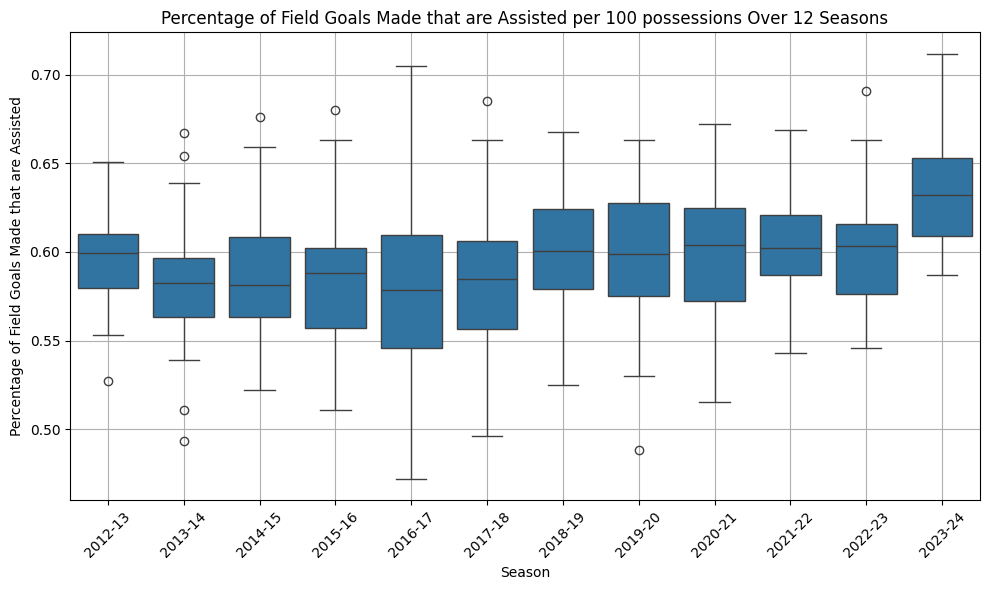

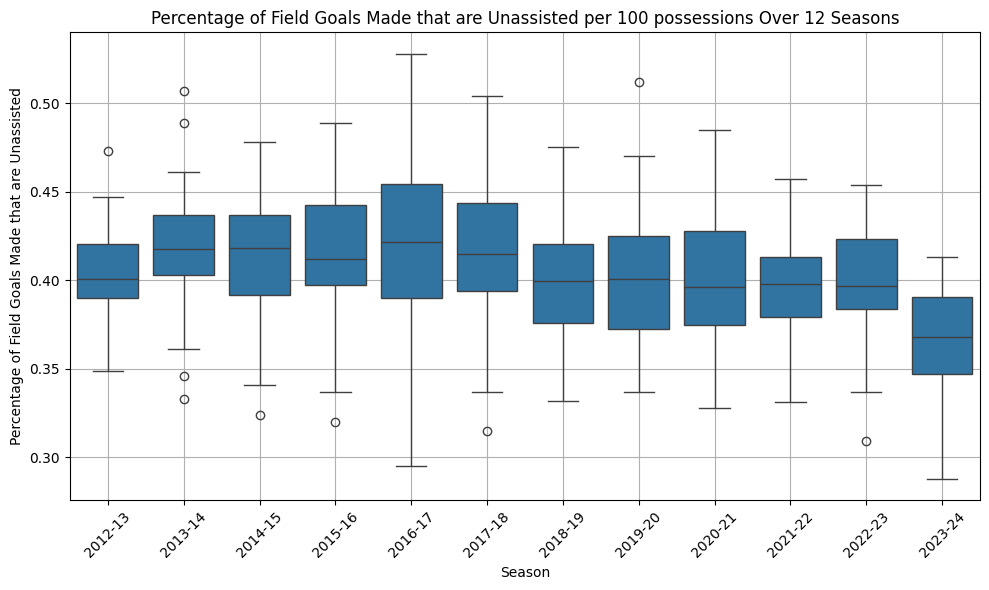

In [12]:

# Assuming team_stats_simple is already loaded and contains the data
# Dictionary for statistic names
stat_name_dict = {
    "PCT_FGA_2PT": "Percentage of Field Goals Attempted that are 2-Pointers",
    "PCT_FGA_3PT": "Percentage of Field Goals Attempted that are 3-Pointers",
    "PCT_PTS_2PT": "Percentage of Points that are 2-Pointers",
    "PCT_PTS_2PT_MR": "Percentage of Points that are Mid-Range 2-Pointers",
    "PCT_PTS_3PT": "Percentage of Points that are 3-Pointers",
    "PCT_PTS_FB": "Percentage of Points that are Fast Break Points",
    "PCT_PTS_FT": "Percentage of Points that are Free Throws",
    "PCT_PTS_OFF_TOV": "Percentage of Points that came after Turnovers",
    "PCT_PTS_PAINT": "Percentage of Points that are in the Paint",
    "PCT_AST_2PM": "Percentage of 2-Point Field Goals that are Assisted",
    "PCT_UAST_2PM": "Percentage of 2-Point Field Goals that are Unassisted",
    "PCT_AST_3PM": "Percentage of 3-Point Field Goals that are Assisted",
    "PCT_UAST_3PM": "Percentage of 3-Point Field Goals that are Unassisted",
    "PCT_AST_FGM": "Percentage of Field Goals Made that are Assisted",
    "PCT_UAST_FGM": "Percentage of Field Goals Made that are Unassisted"
}

# Plot boxplots for each statistic per season
for col in ["PCT_FGA_2PT","PCT_FGA_3PT","PCT_PTS_2PT","PCT_PTS_2PT_MR","PCT_PTS_3PT","PCT_PTS_FB","PCT_PTS_FT","PCT_PTS_OFF_TOV","PCT_PTS_PAINT","PCT_AST_2PM","PCT_UAST_2PM","PCT_AST_3PM","PCT_UAST_3PM","PCT_AST_FGM","PCT_UAST_FGM"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=team_stats_simple, x="SEASON", y=col)
    plt.title(f"{stat_name_dict[col]} per 100 possessions Over 12 Seasons")
    plt.xlabel("Season")
    plt.ylabel(stat_name_dict[col])
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

A Scoring csoport trendjei szintén várhatónak mondhatóak az előzőek alapján. A csapatok eltolták a dobás kísérleteket a hárompontosak irányába, aminek a legnagyobb elszenvedője a középtávoli (Mid Range) dobás volt, ami tulajdonképpen eltűnt a ligából (legalábbis az alapszakaszban, a rájátszás során még mindig nagyon fontos jól dobni ezt a dobásfajtát). A pontok egyre kevesebb százaléka érkezett büntetőkből, valamint eladott labdák után, ami szintén nem meglepő az előzőek fényében.

A többi csoport statisztikái vagy szerepeltek már, vagy nem lenne értelme a trendeket vizsgálni, ezért ezeket mellőzöm.

## Liga szintű dobás statisztikák zónánként

In [13]:
shooting_averages = pd.read_csv("data/shooting_averages_2012_to_2023.csv")
shooting_averages

GRID_TYPE    SHOT_ZONE_BASIC         SHOT_ZONE_AREA  \
0    League Averages  Above the Break 3         Back Court(BC)   
1    League Averages  Above the Break 3              Center(C)   
2    League Averages  Above the Break 3   Left Side Center(LC)   
3    League Averages  Above the Break 3  Right Side Center(RC)   
4    League Averages          Backcourt         Back Court(BC)   
..               ...                ...                    ...   
235  League Averages          Mid-Range  Right Side Center(RC)   
236  League Averages          Mid-Range          Right Side(R)   
237  League Averages          Mid-Range          Right Side(R)   
238  League Averages    Restricted Area              Center(C)   
239  League Averages     Right Corner 3          Right Side(R)   

     SHOT_ZONE_RANGE    FGA    FGM  FG_PCT   SEASON  
0    Back Court Shot     72      2   0.028  2012-13  
1            24+ ft.   8133   2795   0.344  2012-13  
2            24+ ft.  14414   5001   0.347  2012-13  
3            24+ ft.  14958   5352   0.358  2012-13  
4    Back Court Shot    455      8   0.018  2012-13  
..               ...    ...    ...     ...      ...  
235        16-24 ft.   3736   1479   0.396  2023-24  
236        16-24 ft.   1309    530   0.405  2023-24  
237         8-16 ft.   5450   2355   0.432  2023-24  
238  Less Than 8 ft.  68611  45421   0.662  2023-24  
239          24+ ft.  11335   4445   0.392  2023-24  

[240 rows x 8 columns]

In [50]:
shooting_averages.describe()

FGA           FGM      FG_PCT
count    240.000000    240.000000  240.000000
mean   11087.104167   5098.925000    0.372750
std    15056.302633   9216.042705    0.122887
min       34.000000      2.000000    0.012000
25%     2237.000000    973.500000    0.365500
50%     6986.000000   2802.500000    0.394500
75%    12269.750000   5006.250000    0.417000
max    76666.000000  48198.000000    0.665000

In [51]:
shooting_averages.isna().sum()  

GRID_TYPE          0
SHOT_ZONE_BASIC    0
SHOT_ZONE_AREA     0
SHOT_ZONE_RANGE    0
FGA                0
FGM                0
FG_PCT             0
SEASON             0
dtype: int64

Ahogy korábban említettem, két féle dobás zóna csoportosítást használ az NBA. Először az egyszerűbbet mutatom be:

In [14]:
shooting_averages.SHOT_ZONE_BASIC.unique()

array(['Above the Break 3', 'Backcourt', 'In The Paint (Non-RA)',
       'Left Corner 3', 'Mid-Range', 'Restricted Area', 'Right Corner 3'],
      dtype=object)

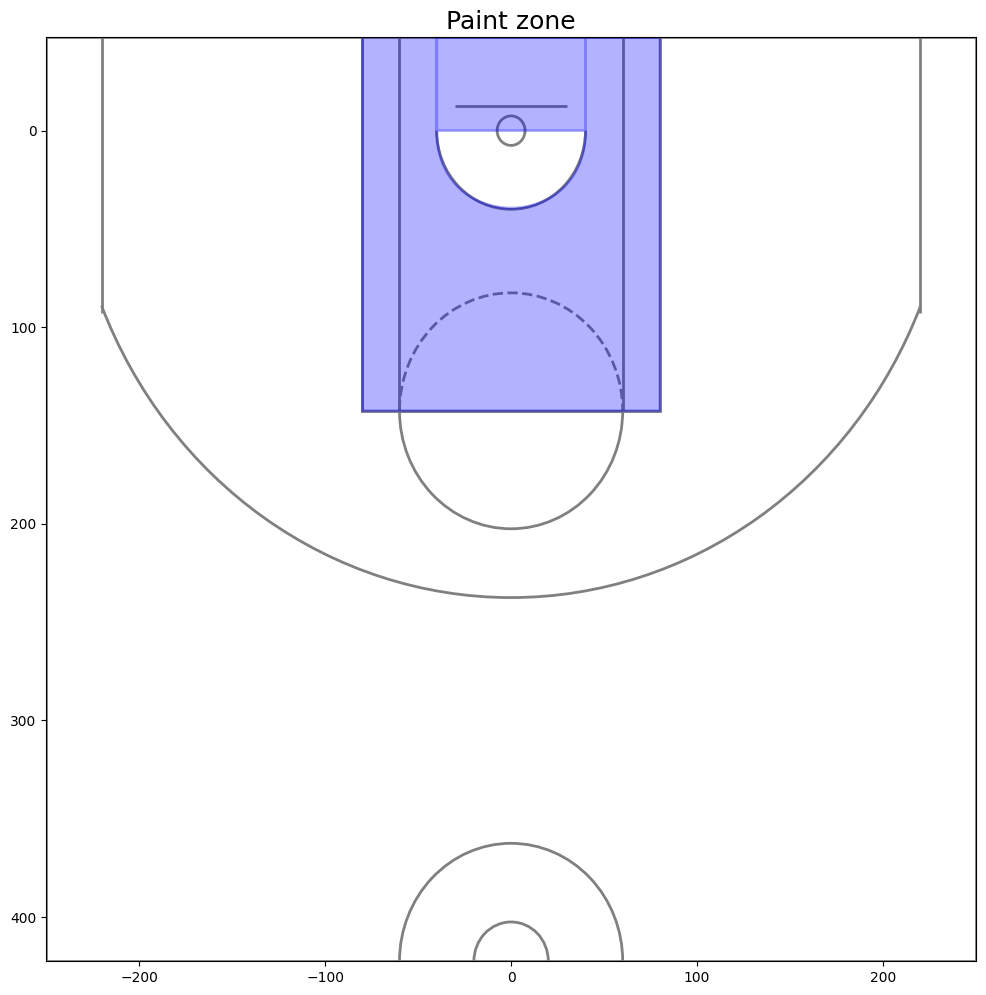

In [21]:
from plotting_functions import draw_paint

fig,ax = plt.subplots(figsize=(12,12))
draw_court(ax,outer_lines=True)
draw_paint(ax)

xlim=(-250, 250)
ylim=(422.5, -47.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.tick_params(labelbottom="off", labelleft="off")
ax.set_title("Paint zone", fontsize=18)
plt.show()

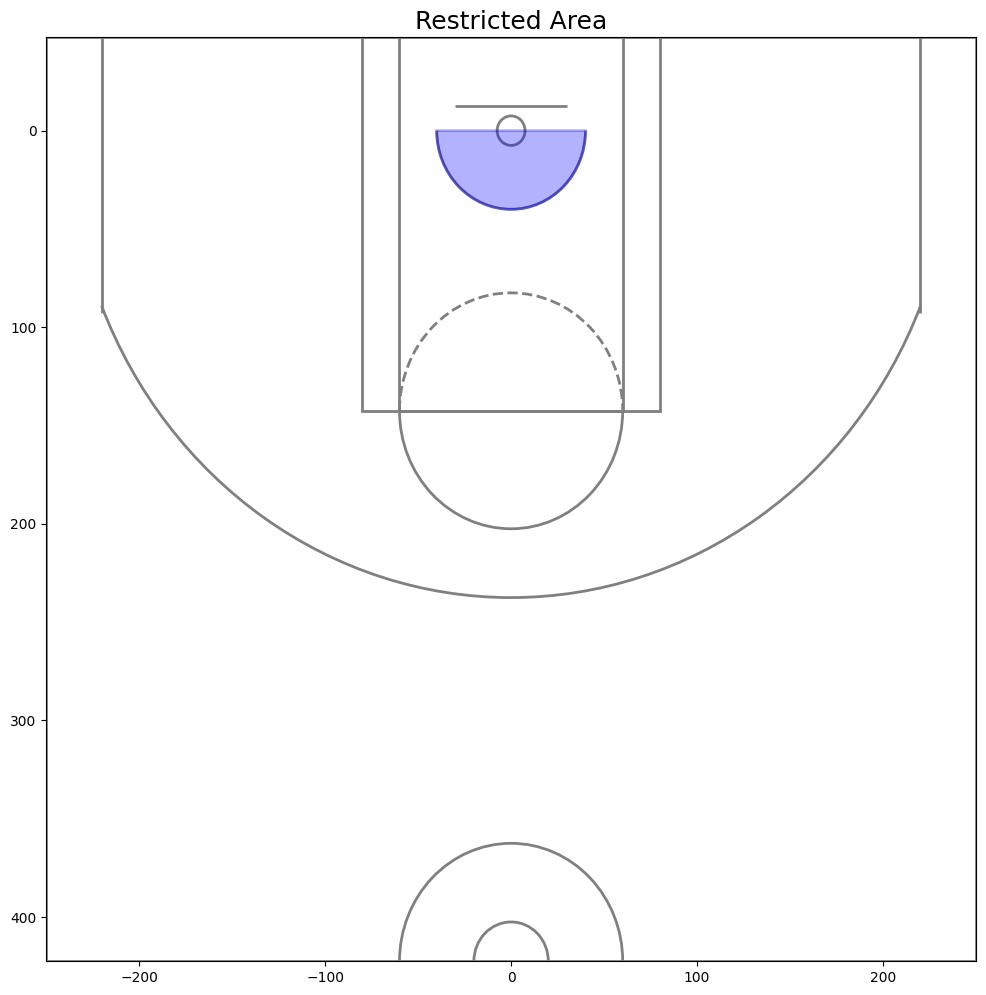

In [22]:
from plotting_functions import draw_restricted_area

fig,ax = plt.subplots(figsize=(12,12))
draw_court(ax,outer_lines=True)
draw_restricted_area(ax)

xlim=(-250, 250)
ylim=(422.5, -47.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.tick_params(labelbottom="off", labelleft="off")
ax.set_title("Restricted Area", fontsize=18)
plt.show()

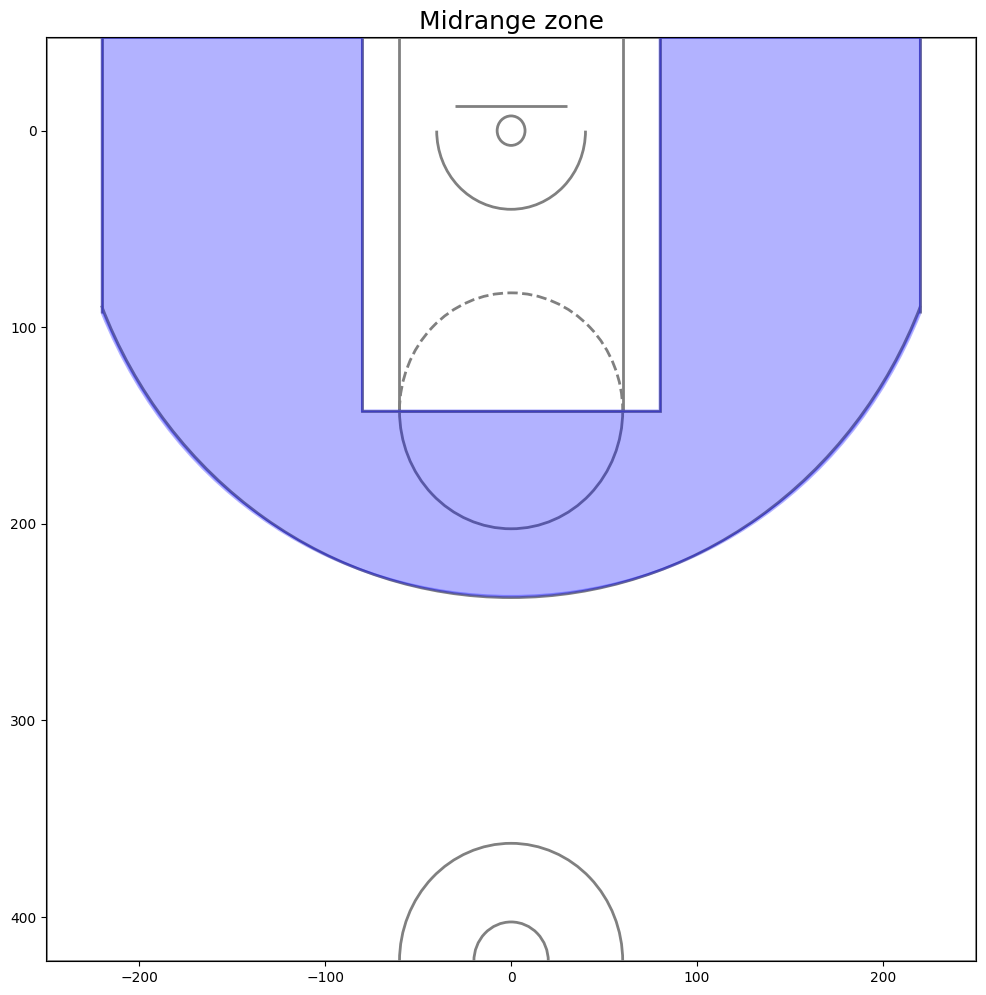

In [26]:
from plotting_functions import draw_midrange

fig,ax = plt.subplots(figsize=(12,12))
draw_court(ax,outer_lines=True)
draw_midrange(ax)

xlim=(-250, 250)
ylim=(422.5, -47.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.tick_params(labelbottom="off", labelleft="off")
ax.set_title("Midrange zone", fontsize=18)
plt.show()

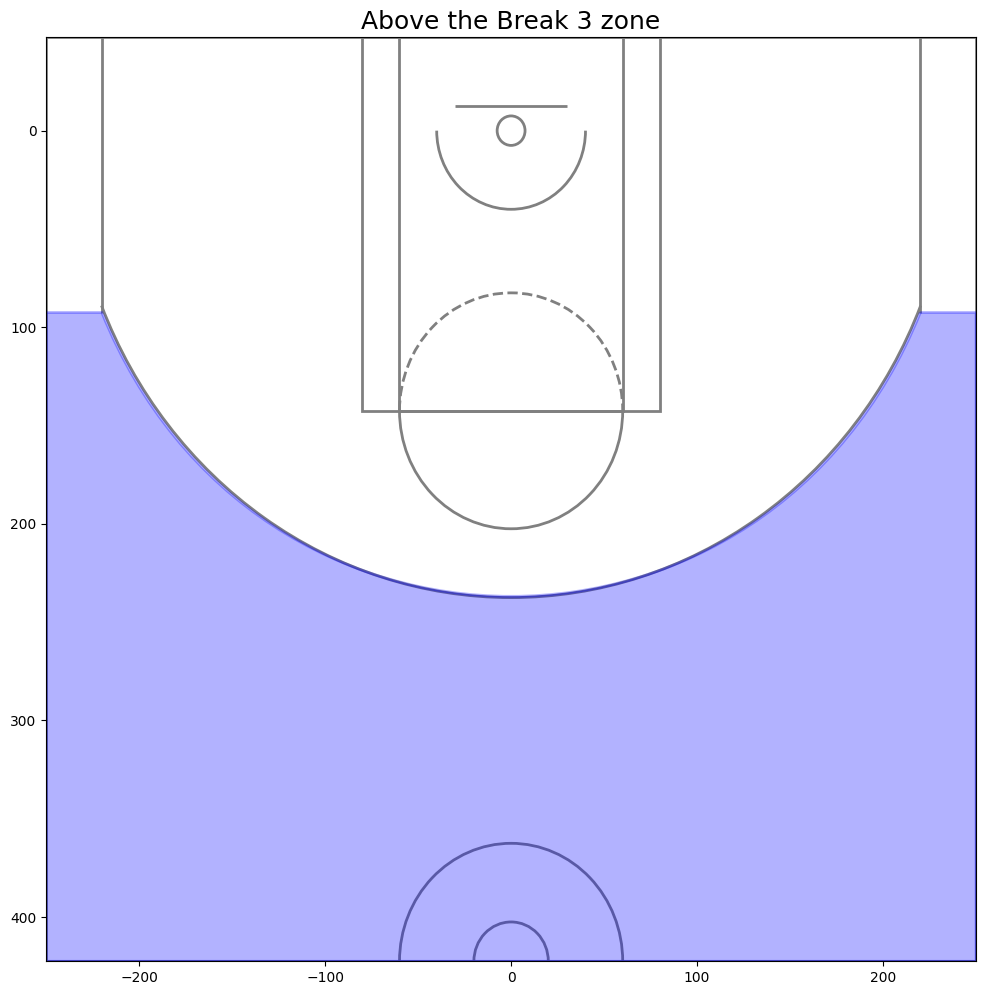

In [20]:
from plotting_functions import draw_court, draw_above_the_break_3

fig,ax = plt.subplots(figsize=(12,12))
draw_court(ax,outer_lines=True)
draw_above_the_break_3(ax)

xlim=(-250, 250)
ylim=(422.5, -47.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.tick_params(labelbottom="off", labelleft="off")
ax.set_title("Above the Break 3 zone", fontsize=18)
plt.show()

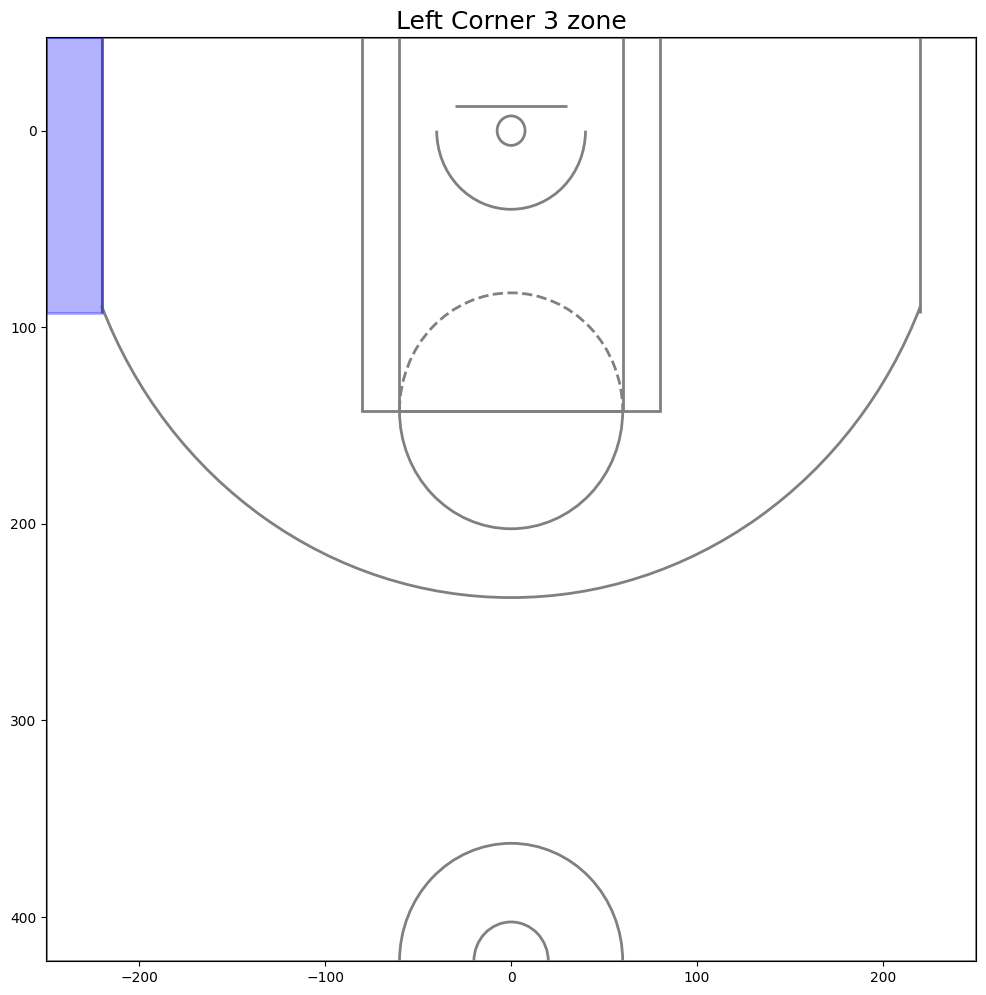

In [23]:
from plotting_functions import draw_left_three_point_corner

fig,ax = plt.subplots(figsize=(12,12))
draw_court(ax,outer_lines=True)
draw_left_three_point_corner(ax)

xlim=(-250, 250)
ylim=(422.5, -47.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.tick_params(labelbottom="off", labelleft="off")
ax.set_title("Left Corner 3 zone", fontsize=18)
plt.show()


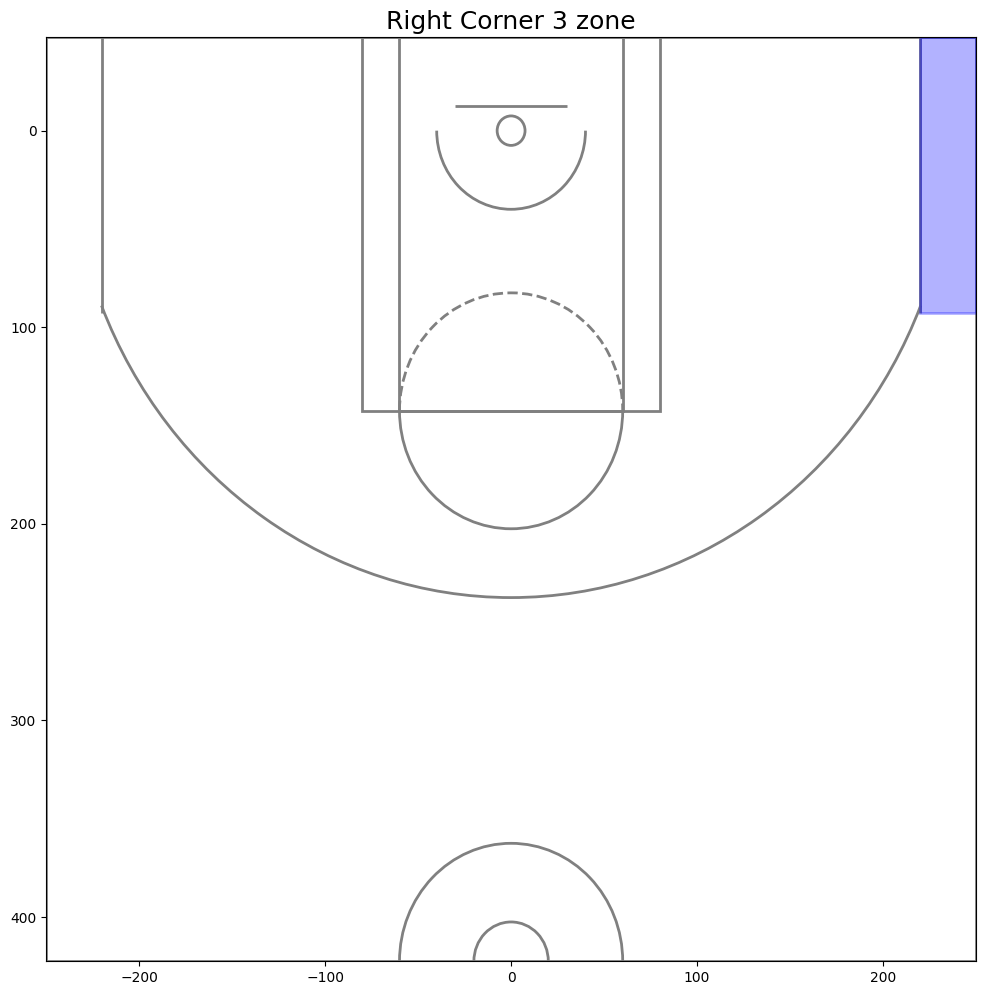

In [25]:
from plotting_functions import draw_right_three_point_corner

fig,ax = plt.subplots(figsize=(12,12))
draw_court(ax,outer_lines=True)
draw_right_three_point_corner(ax)

xlim=(-250, 250)
ylim=(422.5, -47.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.tick_params(labelbottom="off", labelleft="off")
ax.set_title("Right Corner 3 zone", fontsize=18)
plt.show()

A Backcourt zóna a játékos saját térfele, ezt ne mutatom meg.

A másik csoportosítást ritkábban használják, ezeket konkrét dobásokkal mutatom meg.

In [27]:
shooting_averages.SHOT_ZONE_AREA.unique()

array(['Back Court(BC)', 'Center(C)', 'Left Side Center(LC)',
       'Right Side Center(RC)', 'Left Side(L)', 'Right Side(R)'],
      dtype=object)

In [29]:
shotchart_2012 = pd.read_csv('data/nba_shotdata_2012.csv')

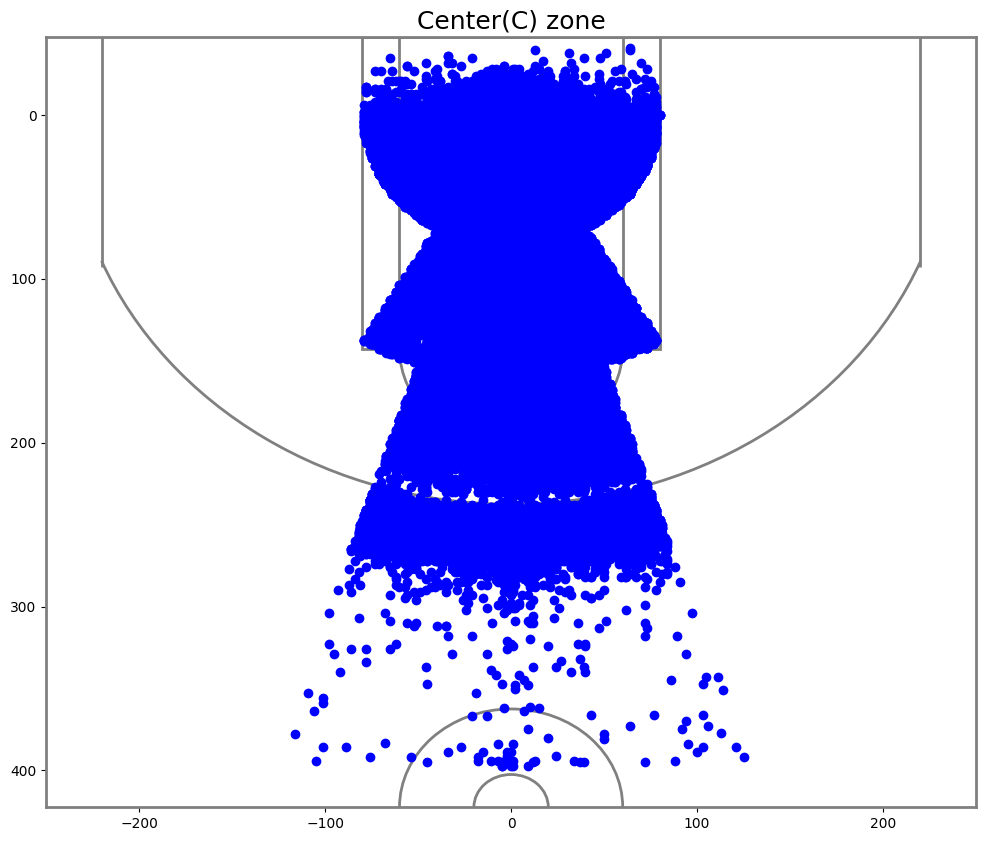

In [30]:
from plotting_functions import shot_chart

fig, ax = plt.subplots(figsize=(12,10))
shot_chart(data=shotchart_2012[shotchart_2012["SHOT_ZONE_AREA"] == "Center(C)"], x='LOC_X', y='LOC_Y', kind='scatter', title='Center(C) zone', cmap="Reds", ax=ax, draw_zones=False)
plt.show()

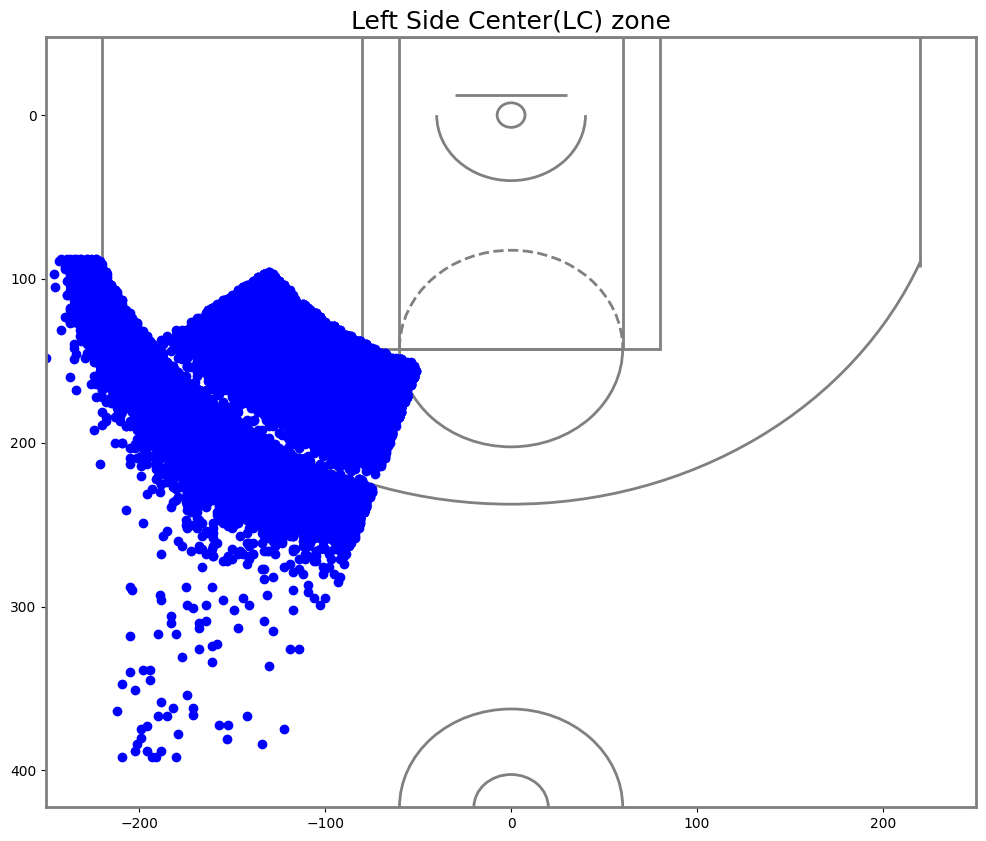

In [31]:
from plotting_functions import shot_chart

fig, ax = plt.subplots(figsize=(12,10))
shot_chart(data=shotchart_2012[shotchart_2012["SHOT_ZONE_AREA"] == 'Left Side Center(LC)'], x='LOC_X', y='LOC_Y', kind='scatter', title='Left Side Center(LC) zone', cmap="Reds", ax=ax, draw_zones=False)
plt.show()

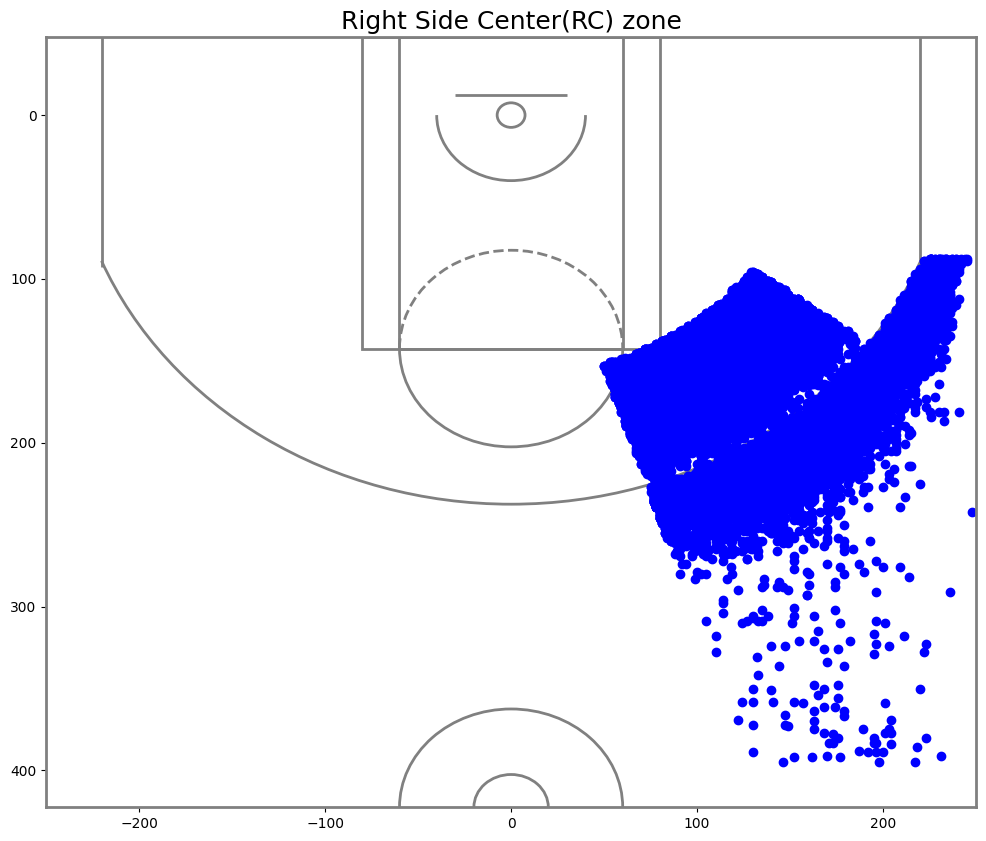

In [32]:
from plotting_functions import shot_chart

fig, ax = plt.subplots(figsize=(12,10))
shot_chart(data=shotchart_2012[shotchart_2012["SHOT_ZONE_AREA"] == 'Right Side Center(RC)'], x='LOC_X', y='LOC_Y', kind='scatter', title='Right Side Center(RC) zone', cmap="Reds", ax=ax, draw_zones=False)
plt.show()

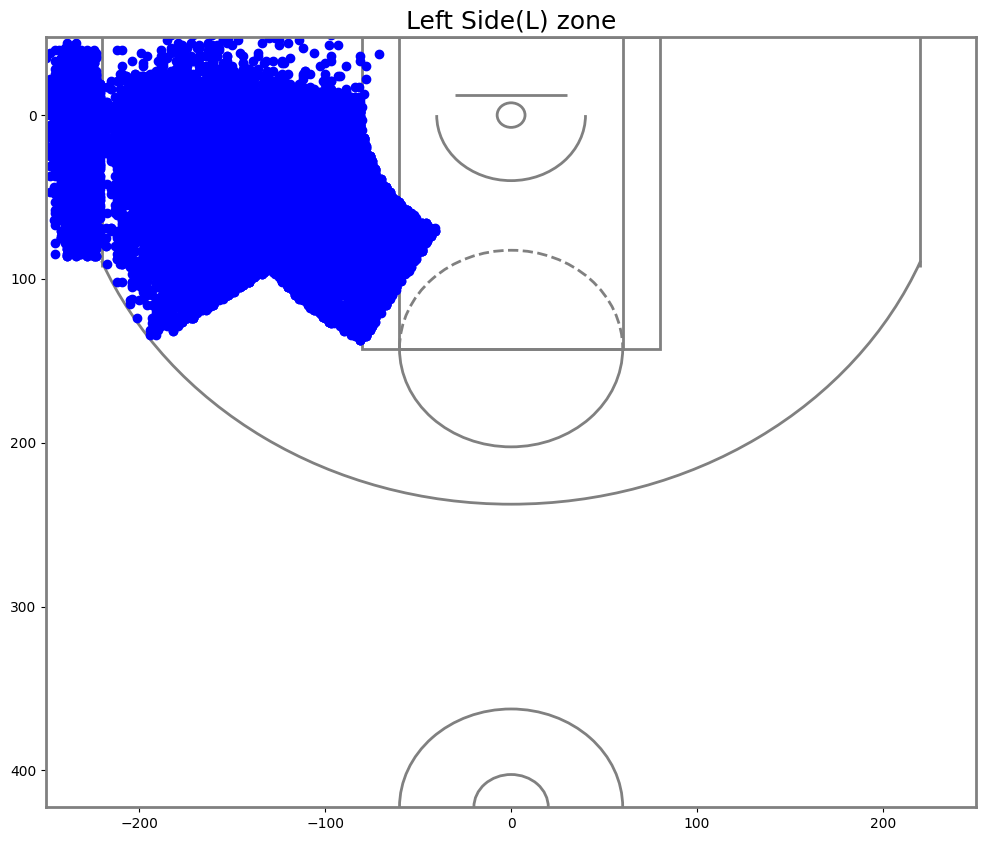

In [33]:
from plotting_functions import shot_chart

fig, ax = plt.subplots(figsize=(12,10))
shot_chart(data=shotchart_2012[shotchart_2012["SHOT_ZONE_AREA"] == 'Left Side(L)'], x='LOC_X', y='LOC_Y', kind='scatter', title='Left Side(L) zone', cmap="Reds", ax=ax, draw_zones=False)
plt.show()

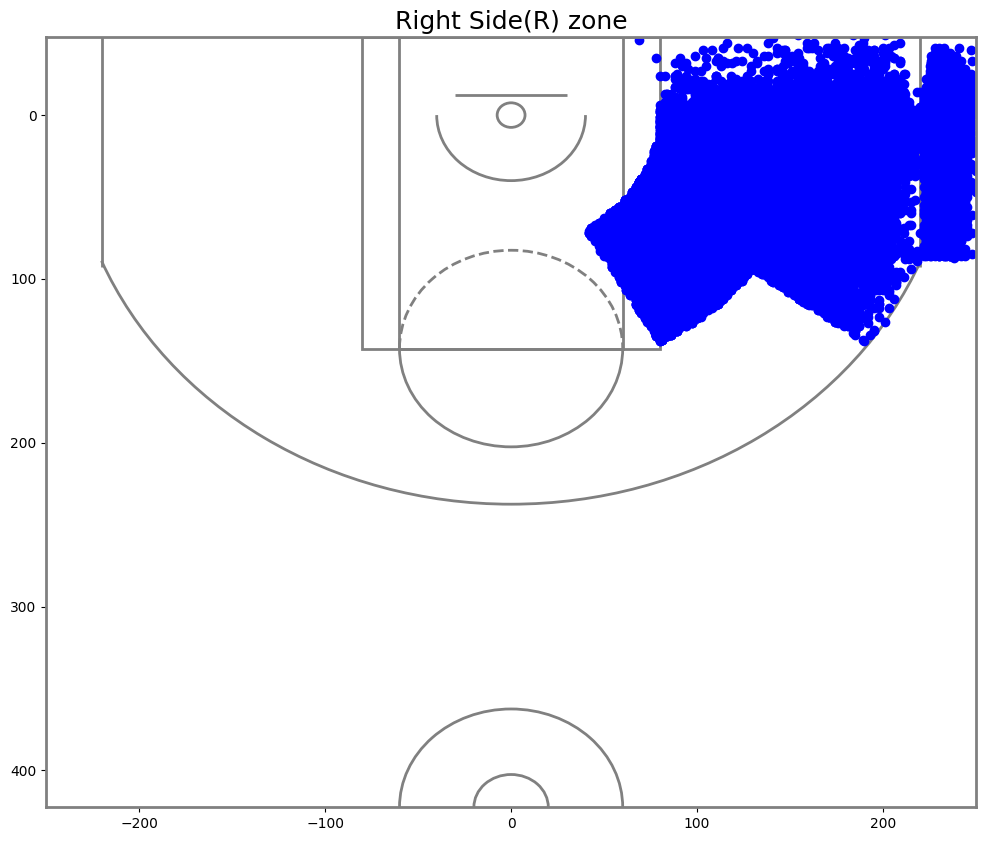

In [34]:
from plotting_functions import shot_chart

fig, ax = plt.subplots(figsize=(12,10))
shot_chart(data=shotchart_2012[shotchart_2012["SHOT_ZONE_AREA"] == 'Right Side(R)'], x='LOC_X', y='LOC_Y', kind='scatter', title='Right Side(R) zone', cmap="Reds", ax=ax, draw_zones=False)
plt.show()

In [43]:
shooting_averages

GRID_TYPE    SHOT_ZONE_BASIC         SHOT_ZONE_AREA  \
0    League Averages  Above the Break 3         Back Court(BC)   
1    League Averages  Above the Break 3              Center(C)   
2    League Averages  Above the Break 3   Left Side Center(LC)   
3    League Averages  Above the Break 3  Right Side Center(RC)   
4    League Averages          Backcourt         Back Court(BC)   
..               ...                ...                    ...   
235  League Averages          Mid-Range  Right Side Center(RC)   
236  League Averages          Mid-Range          Right Side(R)   
237  League Averages          Mid-Range          Right Side(R)   
238  League Averages    Restricted Area              Center(C)   
239  League Averages     Right Corner 3          Right Side(R)   

     SHOT_ZONE_RANGE    FGA    FGM  FG_PCT   SEASON  
0    Back Court Shot     72      2   0.028  2012-13  
1            24+ ft.   8133   2795   0.344  2012-13  
2            24+ ft.  14414   5001   0.347  2012-13  
3            24+ ft.  14958   5352   0.358  2012-13  
4    Back Court Shot    455      8   0.018  2012-13  
..               ...    ...    ...     ...      ...  
235        16-24 ft.   3736   1479   0.396  2023-24  
236        16-24 ft.   1309    530   0.405  2023-24  
237         8-16 ft.   5450   2355   0.432  2023-24  
238  Less Than 8 ft.  68611  45421   0.662  2023-24  
239          24+ ft.  11335   4445   0.392  2023-24  

[240 rows x 8 columns]

In [42]:
shots_attempted = shooting_averages.groupby(["SEASON", "SHOT_ZONE_BASIC"]).sum().reset_index()
shots_attempted

SEASON        SHOT_ZONE_BASIC  \
0   2012-13      Above the Break 3   
1   2012-13              Backcourt   
2   2012-13  In The Paint (Non-RA)   
3   2012-13          Left Corner 3   
4   2012-13              Mid-Range   
..      ...                    ...   
79  2023-24  In The Paint (Non-RA)   
80  2023-24          Left Corner 3   
81  2023-24              Mid-Range   
82  2023-24        Restricted Area   
83  2023-24         Right Corner 3   

                                            GRID_TYPE  \
0   League AveragesLeague AveragesLeague AveragesL...   
1                                     League Averages   
2   League AveragesLeague AveragesLeague AveragesL...   
3                                     League Averages   
4   League AveragesLeague AveragesLeague AveragesL...   
..                                                ...   
79  League AveragesLeague AveragesLeague AveragesL...   
80                                    League Averages   
81  League AveragesLeague AveragesLeague AveragesL...   
82                                    League Averages   
83                                    League Averages   

                                       SHOT_ZONE_AREA  \
0   Back Court(BC)Center(C)Left Side Center(LC)Rig...   
1                                      Back Court(BC)   
2         Center(C)Center(C)Left Side(L)Right Side(R)   
3                                        Left Side(L)   
4   Center(C)Center(C)Left Side Center(LC)Left Sid...   
..                                                ...   
79        Center(C)Center(C)Left Side(L)Right Side(R)   
80                                       Left Side(L)   
81  Center(C)Center(C)Left Side Center(LC)Left Sid...   
82                                          Center(C)   
83                                      Right Side(R)   

                                      SHOT_ZONE_RANGE    FGA    FGM  FG_PCT  
0                Back Court Shot24+ ft.24+ ft.24+ ft.  37577  13150   1.077  
1                                     Back Court Shot    455      8   0.018  
2             8-16 ft.Less Than 8 ft.8-16 ft.8-16 ft.  31355  12115   1.582  
3                                             24+ ft.   7534   2906   0.386  
4   16-24 ft.8-16 ft.16-24 ft.8-16 ft.16-24 ft.16-...  60849  23832   3.154  
..                                                ...    ...    ...     ...  
79            8-16 ft.Less Than 8 ft.8-16 ft.8-16 ft.  45779  20150   1.767  
80                                            24+ ft.  12242   4701   0.384  
81  16-24 ft.8-16 ft.16-24 ft.8-16 ft.16-24 ft.16-...  26321  11065   3.358  
82                                    Less Than 8 ft.  68611  45421   0.662  
83                                            24+ ft.  11335   4445   0.392  

[84 rows x 8 columns]

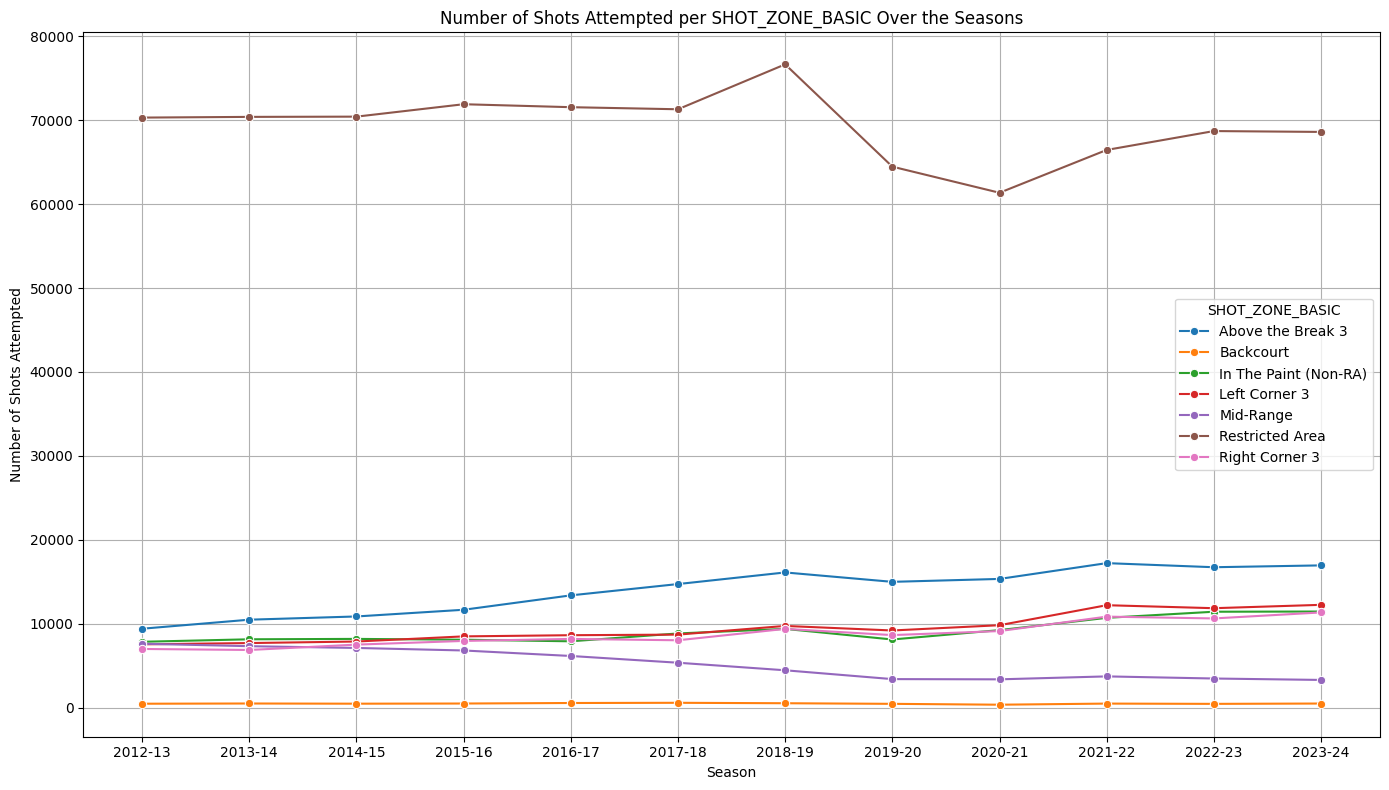

In [47]:
# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=shooting_averages, x="SEASON", y="FGA", hue="SHOT_ZONE_BASIC", marker="o", errorbar=None)
plt.title("Number of Shots Attempted per SHOT_ZONE_BASIC Over the Seasons")
plt.xlabel("Season")
plt.ylabel("Number of Shots Attempted")
plt.grid(True)
plt.tight_layout()
plt.show()

Ahogy korábban is láttuk, itt is megerősödik, hogy az évek során egyre kevesebb középtávoli (Mid-Range) dobás kísérlet volt, és egyre több tripla. Érdekes viszont, hogy a 2018-19-es szeon után két évig egyre kevesebb dobást kíséreltek meg a csapatok a gyűrű közvetlen közeléből (Restricted Area).

In [36]:
shooting_averages.SHOT_ZONE_BASIC.value_counts()

SHOT_ZONE_BASIC
Mid-Range                96
Above the Break 3        48
In The Paint (Non-RA)    48
Backcourt                12
Left Corner 3            12
Restricted Area          12
Right Corner 3           12
Name: count, dtype: int64

A zónák bemutatása során látottakhoz a dobásokat tartalmazó adathalmaz bemutatása sokban nem tenne hozzá, ezért betöltés után csak kiíratom az alapvető statisztikákat és a nanok számát.

In [48]:
shots_all = pd.read_csv("data/nba_shots_2012_to_2023.csv")
shots_all.describe()

GAME_ID  GAME_EVENT_ID     PLAYER_ID       TEAM_ID        PERIOD  \
count  2.309464e+06   2.309464e+06  2.309464e+06  2.309464e+06  2.309464e+06   
mean   2.175219e+07   2.940258e+02  6.747896e+05  1.610613e+09  2.478944e+00   
std    3.471963e+05   1.840646e+02  6.962373e+05  8.659441e+00  1.135482e+00   
min    2.120000e+07   1.000000e+00  2.550000e+02  1.610613e+09  1.000000e+00   
25%    2.150004e+07   1.340000e+02  2.019330e+05  1.610613e+09  1.000000e+00   
50%    2.170118e+07   2.880000e+02  2.031140e+05  1.610613e+09  2.000000e+00   
75%    2.210014e+07   4.380000e+02  1.627788e+06  1.610613e+09  3.000000e+00   
max    2.230123e+07   1.012000e+03  1.642013e+06  1.610613e+09  8.000000e+00   

       MINUTES_REMAINING  SECONDS_REMAINING  SHOT_DISTANCE         LOC_X  \
count       2.309464e+06       2.309464e+06   2.309464e+06  2.309464e+06   
mean        5.352131e+00       2.881328e+01   1.295919e+01 -1.087900e+00   
std         3.451284e+00       1.743528e+01   1.031636e+01  1.103814e+02   
min         0.000000e+00       0.000000e+00   0.000000e+00 -2.500000e+02   
25%         2.000000e+00       1.400000e+01   2.000000e+00 -4.900000e+01   
50%         5.000000e+00       2.900000e+01   1.300000e+01  0.000000e+00   
75%         8.000000e+00       4.400000e+01   2.400000e+01  4.700000e+01   
max         1.200000e+01       5.900000e+01   8.800000e+01  2.500000e+02   

              LOC_Y  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG     GAME_DATE  
count  2.309464e+06            2309464.0    2.309464e+06  2.309464e+06  
mean   8.934664e+01                  1.0    4.624900e-01  2.018205e+07  
std    9.253451e+01                  0.0    4.985911e-01  3.503711e+04  
min   -5.200000e+01                  1.0    0.000000e+00  2.012103e+07  
25%    1.100000e+01                  1.0    0.000000e+00  2.015103e+07  
50%    4.800000e+01                  1.0    0.000000e+00  2.018040e+07  
75%    1.690000e+02                  1.0    1.000000e+00  2.021111e+07  
max    8.780000e+02                  1.0    1.000000e+00  2.024041e+07

In [49]:
shots_all.isna().sum()

GRID_TYPE              0
GAME_ID                0
GAME_EVENT_ID          0
PLAYER_ID              0
PLAYER_NAME            0
TEAM_ID                0
TEAM_NAME              0
PERIOD                 0
MINUTES_REMAINING      0
SECONDS_REMAINING      0
EVENT_TYPE             0
ACTION_TYPE            0
SHOT_TYPE              0
SHOT_ZONE_BASIC        0
SHOT_ZONE_AREA         0
SHOT_ZONE_RANGE        0
SHOT_DISTANCE          0
LOC_X                  0
LOC_Y                  0
SHOT_ATTEMPTED_FLAG    0
SHOT_MADE_FLAG         0
GAME_DATE              0
HTM                    0
VTM                    0
dtype: int64

## Megválaszolandó kérdések
* Mi volt a kívánatos dobási térkép az egyes években? 
* Milyen statisztikai mutatókban kellet jól teljesíteni ahhoz, hogy jó támadást/védekezést rakjon össze egy csapat?
## Elemzés és vizualizáció jellege, technólógiája
A feladat végén egy dash+plotly weboldalt szeretnék készíteni, ahol a csapatok dobástérképét és statisztikai mutatóit lehet megnézni, egy dashboardhoz hasonlóan.